# 1.   Data Extraction


## 1.1. Import Files and Packages

In [ ]:
!pip install fredapi wbdata

import pandas as pd
import re
import numpy as np
import yfinance as yf
import pandas as pd
import requests
import time
import os

from collections import Counter
from fredapi import Fred
from datetime import datetime
from IPython.display import display

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1.2. Read Files

### 1.2.1. Firm-Level Data

In [ ]:
# File 1 - merge on firm_id only - Preqin via WRDS
file1 = '/content/drive/MyDrive/Capstone Data/Preqin Manager Details (General Partners) Data.csv'
df1 = pd.read_csv(file1)
df1 = df1.drop_duplicates()

# File 2 - merge on firm_id only - Preqin Pro
file2 = '/content/drive/MyDrive/Capstone Data/Preqin Pro Fund Managers Data.xlsx'
df2 = pd.read_excel(file2)
df2 = df2.drop_duplicates()

### 1.2.2. Fund-Level Data

In [ ]:
# File 3
file3 = '/content/drive/MyDrive/Capstone Data/Preqin Fund Details (General Partners) Data.csv'
df3 = pd.read_csv(file3)
df3 = df3.drop_duplicates()

In [ ]:
# File 4
file4 = '/content/drive/MyDrive/Capstone Data/Preqin Pro Funds Data.xlsx'
df4 = pd.read_excel(file4)
df4 = df4.drop_duplicates()

In [ ]:
# File 5
file5 = '/content/drive/MyDrive/Capstone Data/Preqin Pro Performance Data.xlsx'
df5 = pd.read_excel(file5)
df5 = df5.drop_duplicates()

In [ ]:
# File 6
file6 = '/content/drive/MyDrive/Capstone Data/Preqin Cash Flow (Cash Flow) Data.csv'
df6 = pd.read_csv(file6)
df6 = df6.drop_duplicates()

### 1.2.3. Deal-Level Data

In [ ]:
# File 7 - Merge on portfolio_company_id - Preqin Off-Product Data
file7 = '/content/drive/MyDrive/Capstone Data/Preqin VC Investor Buyer Mapping.txt'
df7 = pd.read_csv(file7, sep="|")
df7 = df7.drop_duplicates()

In [ ]:
# File 8 - Merge on TARGET COMPANY ID and DEAL DATE - Preqin Pro
file8 = '/content/drive/MyDrive/Capstone Data/Preqin Pro Deals Data 1.xlsx'
df8 = pd.read_excel(file8)
df8 = df8.drop_duplicates()

In [ ]:
# File 9 - Merge on TARGET COMPANY ID and DEAL DATE - Preqin Pro
file9 = '/content/drive/MyDrive/Capstone Data/Preqin Pro Deals Data 2.xlsx'
df9 = pd.read_excel(file9)
df9 = df9.drop_duplicates()
df8 = pd.concat([df8,df9], axis=0, ignore_index=True)

# 2. Data Cleaning

## 2.1. Fund-Level Data

### 2.1.1. Merge Data

In [ ]:
df3_columns = [
    "fund_id",
    "firm_id",
    "fund_name",
    "vintage",
    "fund_type",
    "local_currency",
    "fund_status",
    "fund_focus",
    "fund_number_overall",
    "fund_number_series",
    "fund_structure"
]

df4_columns = [
    "FUND ID",
    "FIRM ID",
    "ASSET CLASS",
    "FUND SIZE (USD MN)",
    "SINGLE DEAL FUND",
    "CORE INDUSTRIES",
    "INDUSTRIES",
    "PRIVATE WEALTH"
]

df5_columns = [
    "FUND ID",
    "NET IRR (%)",
    "NET MULTIPLE (X)",
    "RVPI (%)",
    "DPI (%)",
    "CALLED (%)",
    "DATE REPORTED"
]

# Merge df3 and df4
fund_data = pd.merge(df3[df3_columns], df4[df4_columns], left_on=["fund_id"], right_on=["FUND ID"], how="inner")

# Merge fund_data and df5
fund_data = pd.merge(fund_data, df5[df5_columns], left_on=["fund_id"], right_on=["FUND ID"], how="inner")

# Filter for "ASSET CLASS" == "Venture Capital"
fund_data = fund_data[fund_data["ASSET CLASS"] == "Venture Capital"]

# Filter for "vintage" >= 2000
fund_data = fund_data[fund_data['vintage'] >= 2000]

### 2.1.2. Timing Factors Construction

In [ ]:
# Ensure transaction_date is in datetime format.
df6['transaction_date'] = pd.to_datetime(df6['transaction_date'], errors='coerce')

def timedelta_in_years(start, end):
    if pd.isna(start) or pd.isna(end):
        return np.nan
    return (end - start).days / 365.25

def compute_fund_factors(group):
    # Separate transactions by type.
    calls = group[group['transaction_type'] == 'Capital Call']
    dists = group[group['transaction_type'] == 'Distribution']
    values = group[group['transaction_type'] == 'Value']

    # Compute key dates.
    first_call_date = calls['transaction_date'].min()
    final_call_date = calls['transaction_date'].max()
    first_dist_date = dists['transaction_date'].min() if not dists.empty else pd.NaT
    final_dist_date = dists['transaction_date'].max() if not dists.empty else pd.NaT

    # Investment metrics.
    investment_period = timedelta_in_years(first_call_date, final_call_date)
    time_to_first_distribution = timedelta_in_years(first_call_date, first_dist_date)
    total_contribution = calls['transaction_amount'].sum()
    deployment_pace = abs(total_contribution / 1_000_000) / investment_period if investment_period and investment_period > 0 else np.nan

    # Contribution milestones.
    calls_sorted = calls.sort_values('transaction_date')
    cumulative_calls_abs = calls_sorted['transaction_amount'].abs().cumsum()
    abs_total_contribution = calls_sorted['transaction_amount'].abs().sum()
    date_50 = calls_sorted.loc[cumulative_calls_abs >= abs_total_contribution * 0.5, 'transaction_date'].min() if not calls_sorted.empty else pd.NaT
    date_90 = calls_sorted.loc[cumulative_calls_abs >= abs_total_contribution * 0.9, 'transaction_date'].min() if not calls_sorted.empty else pd.NaT
    time_to_50pct_contribution = timedelta_in_years(first_call_date, date_50)
    time_to_90pct_contribution = timedelta_in_years(first_call_date, date_90)

    # Distribution metrics.
    harvesting_period = timedelta_in_years(final_call_date, final_dist_date)
    total_distribution = dists['transaction_amount'].sum()
    distribution_pace = total_distribution / (harvesting_period * 12) if harvesting_period and harvesting_period > 0 else np.nan

    # Valuation dates only.
    if not values.empty:
        first_value_date = values['transaction_date'].min()
        final_value_date = values['transaction_date'].max()
    else:
        first_value_date = pd.NaT
        final_value_date = pd.NaT

    return pd.Series({
        'first_call_date': first_call_date,
        'final_call_date': final_call_date,
        'first_distribution_date': first_dist_date,
        'final_distribution_date': final_dist_date,
        'investment_period': investment_period,
        'time_to_first_distribution': time_to_first_distribution,
        'capital_deployment_pace': deployment_pace,
        'time_to_50pct_contribution': time_to_50pct_contribution,
        'time_to_90pct_contribution': time_to_90pct_contribution,
        'distribution_pace': distribution_pace,
        'total_fund_lifespan': timedelta_in_years(first_call_date, final_dist_date),
        'first_value_date': first_value_date,
        'final_value_date': final_value_date
    })

# Calculate fund factors for each fund_id.
fund_factors = df6.groupby('fund_id', group_keys=False).apply(compute_fund_factors).reset_index()

# Create binary indicators.
fund_factors['Has Call'] = fund_factors['first_call_date'].notna().astype(int)
fund_factors['Has Distribution'] = fund_factors['first_distribution_date'].notna().astype(int)
fund_factors['Has Value'] = fund_factors['first_value_date'].notna().astype(int)

# Use a placeholder date for missing events.
placeholder_date = pd.Timestamp("1900-01-01")
date_impute_map = {
    'first_call_date': 'Has Call',
    'final_call_date': 'Has Call',
    'first_distribution_date': 'Has Distribution',
    'final_distribution_date': 'Has Distribution',
    'first_value_date': 'Has Value',
    'final_value_date': 'Has Value'
}

# Impute placeholder dates.
for col, flag in date_impute_map.items():
    fund_factors.loc[fund_factors[flag] == 0, col] = placeholder_date

# Ensure datetime types.
for col in date_impute_map.keys():
    fund_factors[col] = pd.to_datetime(fund_factors[col], errors='coerce')

# Impute numeric fields with 0 (excluding IDs and binary flags).
numeric_cols = fund_factors.select_dtypes(include=[np.number]).columns.difference(['fund_id', 'Has Call', 'Has Distribution', 'Has Value'])
fund_factors[numeric_cols] = fund_factors[numeric_cols].fillna(0)

# Filter fund_factors to those with fund_id in fund_data.
fund_factors = fund_factors[fund_factors["fund_id"].isin(fund_data["fund_id"])]

<ipython-input-11-7efdee519679>:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fund_factors = df6.groupby('fund_id', group_keys=False).apply(compute_fund_factors).reset_index()


In [ ]:
# Merge fund_data and fund_factors
fund_data = pd.merge(fund_data, fund_factors, on='fund_id', how='inner')

### 2.1.3. Geographical Column Cleaning

In [ ]:
# If fund_focus is 'North America' but local_currency is missing, fill it with 'USD'
fund_data.loc[
    (fund_data['fund_focus'].str.lower() == 'north america') & (fund_data['local_currency'].isna()),
    'local_currency'
] = 'USD'

# If local_currency is 'USD' but fund_focus is missing, fill it with 'North America'
fund_data.loc[
    (fund_data['local_currency'].str.upper() == 'USD') & (fund_data['fund_focus'].isna()),
    'fund_focus'
] = 'North America'

### 2.1.4. Remove Columns with 80% Missing Values

In [ ]:
# Check missing ratio of each column
missing_ratio = fund_data.isna().mean().sort_values(ascending=False)

# Drop columns with more than 80% missing values
high_missing_cols = missing_ratio[missing_ratio > 0.8].index.tolist()
fund_data = fund_data.drop(columns=high_missing_cols)
print("Columns with >80% missing:", high_missing_cols)

Columns with >80% missing: []


### 2.1.5. Fill Value for Categorical Columns

In [ ]:
for col in ['INDUSTRIES']:
    mode_val = fund_data[col].mode(dropna=True)[0]
    fund_data[col] = fund_data[col].fillna(mode_val)

### 2.1.6. Format CORE INDUSTRIES (Fund Region Focus)

In [ ]:
# 1. Drop rows where 'CORE INDUSTRIES' is missing
fund_data = fund_data.dropna(subset=["CORE INDUSTRIES"]).copy()

# 2. Strip whitespace from each industry string
fund_data["CORE INDUSTRIES"] = fund_data["CORE INDUSTRIES"].str.strip()

# 3. Create dummy variables for multi-valued industry column
industry_dummies = fund_data["CORE INDUSTRIES"].str.get_dummies(sep=", ")

# 4. Merge the dummies into the main DataFrame
fund_data = fund_data.join(industry_dummies)

# 5. Optional: drop the original column
fund_data.drop(columns=["CORE INDUSTRIES"], inplace=True)

### 2.1.7. Fill Value for Numerical Columns

In [ ]:
# Define numeric columns to impute
cols_to_fill = [
    'NET MULTIPLE (X)', 'DPI (%)',
    'RVPI (%)', 'CALLED (%)', 'FUND SIZE (USD MN)'
]

irr = ['NET IRR (%)']

# Coerce all to numeric (invalid entries become NaN)
for col in cols_to_fill:
    fund_data[col] = pd.to_numeric(fund_data[col], errors='coerce')

fund_data[irr] = fund_data[irr].apply(pd.to_numeric, errors='coerce')

# Define the grouping for median imputation
group_cols = ['fund_focus', 'fund_type', 'fund_status', 'firm_id']

# Ensure all target columns are numeric
for col in cols_to_fill:
    fund_data[col] = pd.to_numeric(fund_data[col], errors='coerce')

# Impute missing values: group median first, then fallback to global median
for col in cols_to_fill:
    # Group-median imputation
    fund_data[col] = (
        fund_data
        .groupby(group_cols)[col]
        .transform(lambda x: x.fillna(x.median()))
    )
    # Fallback to global median
    fund_data[col] = fund_data[col].fillna(fund_data[col].median())

fund_data = fund_data.dropna(subset='NET IRR (%)')

In [ ]:
# How many NaNs are left after imputation?
print("Remaining NaNs:")
print(fund_data[['NET MULTIPLE (X)', 'NET IRR (%)', 'DPI (%)', 'RVPI (%)', 'CALLED (%)', 'FUND SIZE (USD MN)']].isna().sum())

# Sample problematic rows
print("\nExamples of rows still missing:")
print(fund_data[fund_data['NET MULTIPLE (X)'].isna() | fund_data['NET IRR (%)'].isna()].head())


Remaining NaNs:
NET MULTIPLE (X)      0
NET IRR (%)           0
DPI (%)               0
RVPI (%)              0
CALLED (%)            0
FUND SIZE (USD MN)    0
dtype: int64

Examples of rows still missing:
Empty DataFrame
Columns: [fund_id, firm_id, fund_name, vintage, fund_type, local_currency, fund_status, fund_focus, fund_number_overall, fund_number_series, fund_structure, FUND ID_x, FIRM ID, ASSET CLASS, FUND SIZE (USD MN), SINGLE DEAL FUND, INDUSTRIES, PRIVATE WEALTH, FUND ID_y, NET IRR (%), NET MULTIPLE (X), RVPI (%), DPI (%), CALLED (%), DATE REPORTED, first_call_date, final_call_date, first_distribution_date, final_distribution_date, investment_period, time_to_first_distribution, capital_deployment_pace, time_to_50pct_contribution, time_to_90pct_contribution, distribution_pace, total_fund_lifespan, first_value_date, final_value_date, Has Call, Has Distribution, Has Value, Business Services, Consumer Discretionary, Diversified, Energy & Utilities, Financial & Insurance Services,

## 2.2. Firm-Level Data

### 2.2.1. Merge Data

In [ ]:
df1_columns = [
    "firm_id",
    "firmname",
    "firmtype",
    "sourceofcapital",
    "mainfirmstrategy",
    "firmcity",
    "firmstate",
    "firmcountry",
    "staffcounttotal",
    "staffcountmanagement",
    "staffcountinvestment",
    "totalfundsraised10yearsmn",
    "listed_firm",
    "isminorityowned",
    "iswomenowned"
]

df2_columns = [
    "FIRM ID",
    "FIRM NAME",
    "PE: GEOGRAPHIC EXPOSURE",
    "REGION",
    "PE: INDUSTRIES",
    "PE: INDUSTRY VERTICALS",
    "PE: TOTAL NO. OF FUNDS CLOSED",
    "PE: INVESTOR CO-INVESTMENT RIGHTS",
    "TOTAL:ASSETS UNDER MANAGEMENT (USD MN)",
    "PE: GP POSITION IN INVESTMENT",
    "PE: PORTFOLIO COMPANY MINIMUM EBITDA (USD MN)",
    "PE: PORTFOLIO COMPANY MAXIMUM EBITDA (USD MN)",
    "PE: PORTFOLIO COMPANY MINIMUM VALUE (USD MN)",
    "PE: PORTFOLIO COMPANY MAXIMUM VALUE (USD MN)",
    "PE: BOARD REPRESENTATION",
    "PE: SHARE HOLDING",
    "PE: INVESTMENT STAGE",
    "PE: MINIMUM TRANSACTION SIZE (USD MN)",
    "PE: MAXIMUM TRANSACTION SIZE (USD MN)",
    "PE: MINIMUM HOLDING PERIOD (YEARS)",
    "PE: MAXIMUM HOLDING PERIOD (YEARS)",
    "PE: ESTIMATED DRY POWDER (USD MN)"
]

# Merge df1 and df2 on 'firm_id' and 'FIRM ID'
firm_data = pd.merge(df1[df1_columns], df2[df2_columns], left_on=["firm_id"], right_on=["FIRM ID"], how="inner")

# Filter firm_data to only keep firms that are present in fund_data
firm_data = firm_data[firm_data['firm_id'].isin(fund_data['firm_id'])]

### 2.2.3 Remove Columns with Over 60% of Missing Value

In [ ]:
# Calculate missing percentage for each column
missing_ratio = firm_data.isna().mean()

# Identify columns where more than 60% of the values are missing
columns_to_drop = missing_ratio[missing_ratio > 0.6].index

# Drop those columns from the dataset
firm_data.drop(columns=columns_to_drop, inplace=True)

# Print out the names of the dropped columns
print("Dropped columns with >60% missing values:")
print(list(columns_to_drop))

Dropped columns with >60% missing values:
['PE: INVESTOR CO-INVESTMENT RIGHTS', 'PE: PORTFOLIO COMPANY MINIMUM EBITDA (USD MN)', 'PE: PORTFOLIO COMPANY MAXIMUM EBITDA (USD MN)', 'PE: PORTFOLIO COMPANY MINIMUM VALUE (USD MN)', 'PE: PORTFOLIO COMPANY MAXIMUM VALUE (USD MN)', 'PE: MINIMUM TRANSACTION SIZE (USD MN)', 'PE: MAXIMUM TRANSACTION SIZE (USD MN)', 'PE: MINIMUM HOLDING PERIOD (YEARS)', 'PE: MAXIMUM HOLDING PERIOD (YEARS)']


### 2.2.4 Fill Value for Categorical Columns

In [ ]:
to_check = ['PE: INVESTMENT STAGE',
            'PE: BOARD REPRESENTATION',
            'PE: INDUSTRY VERTICALS',
            'PE: GP POSITION IN INVESTMENT',
            'PE: SHARE HOLDING',
            'PE: GEOGRAPHIC EXPOSURE',
            'sourceofcapital',
            'firmstate',
            'firmcity']

for col in to_check:
    most_freq = firm_data[col].mode(dropna=True)[0]
    firm_data[col] = firm_data[col].fillna(most_freq)

In [ ]:
# Find all numeric columns (for imputation)
numeric_cols = firm_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("Numeric columns:")
print(numeric_cols)

firm_data = firm_data.drop(columns=['FIRM ID'])

Numeric columns:
['firm_id', 'staffcounttotal', 'staffcountmanagement', 'staffcountinvestment', 'totalfundsraised10yearsmn', 'FIRM ID', 'PE: TOTAL NO. OF FUNDS CLOSED', 'TOTAL:ASSETS UNDER MANAGEMENT (USD MN)', 'PE: ESTIMATED DRY POWDER (USD MN)']


### 2.2.5 Fill Value for Numerical Columns

In [ ]:
# Make a safe copy
firm_data = firm_data.copy()

# Columns to impute
cols_to_fill = [
    'TOTAL:ASSETS UNDER MANAGEMENT (USD MN)',
    'totalfundsraised10yearsmn',
    'PE: ESTIMATED DRY POWDER (USD MN)',
    'staffcountmanagement',
    'staffcounttotal',
    'staffcountinvestment'
]

# Grouping keys for imputation
group_cols = ['firmtype', 'firmcountry', 'sourceofcapital']

# Step 0: Coerce all columns to numeric
for col in cols_to_fill:
    firm_data[col] = pd.to_numeric(firm_data[col], errors='coerce')

# Step 1: Impute missing values using group-wise medians
for col in cols_to_fill:
    firm_data[col] = (
        firm_data
        .groupby(group_cols)[col]
        .transform(lambda x: x.fillna(x.median()))
    )

# Step 2: Fill remaining NAs (still not imputed) with global median
for col in cols_to_fill:
    firm_data[col] = firm_data[col].fillna(firm_data[col].median())

# Step 3: Show remaining missingness (should now be zero if everything is numeric)
missing_summary = firm_data.isna().sum().to_frame(name='Missing Count')
missing_summary['Total Rows'] = len(firm_data)
missing_summary['Missing %'] = (missing_summary['Missing Count'] / missing_summary['Total Rows']) * 100
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
missing_summary = missing_summary.sort_values(by='Missing %', ascending=False)

# Step 4: Print or inspect
print("Remaining missing values:")
print(missing_summary.head(20))

# Optional: List all numeric columns
numeric_cols = firm_data.select_dtypes(include=['float64', 'int64']).columns.tolist()


Remaining missing values:
Empty DataFrame
Columns: [Missing Count, Total Rows, Missing %]
Index: []


### 2.2.7. Format PE: INDUSTRIES (Firm Industry Focus)

In [ ]:
# 1. Drop rows with missing PE: INDUSTRIES and make a safe copy
firm_data = firm_data.dropna(subset=["PE: INDUSTRIES"]).copy()

# 2. Clean whitespace from strings
firm_data["PE: INDUSTRIES"] = firm_data["PE: INDUSTRIES"].str.strip()

# 3. Create dummy variables from comma-separated values
industry_dummies = firm_data["PE: INDUSTRIES"].str.get_dummies(sep=", ")

# 4. Join dummy variables into the DataFrame
firm_data = pd.concat([firm_data, industry_dummies], axis=1)

# 5. Define sector mappings
industry_group_map = {
    'Business Services (Firm)': [
        'Business Services', 'Business Support Services', 'Outsourcing', 'Marketing/Advertising', 'Education/Training'
    ],
    'Consumer Discretionary (Firm)': [
        'Consumer Discretionary', 'Consumer Products', 'Consumer Services', 'Retail', 'Travel & Leisure'
    ],
    'Diversified (Firm)': ['Diversified'],
    'Energy & Utilities (Firm)': [
        'Energy & Utilities', 'Power & Utilities', 'Oil & Gas', 'Renewable Energy', 'Energy Storage & Batteries'
    ],
    'Financial & Insurance Services (Firm)': [
        'Financial & Insurance Services', 'Financial Services', 'Insurance'
    ],
    'Healthcare (Firm)': [
        'Healthcare', 'Healthcare IT', 'Healthcare Specialists', 'Medical Devices & Equipment', 'Pharmaceuticals'
    ],
    'Industrials (Firm)': [
        'Industrials', 'Industrial Machinery', 'Construction', 'Heating', 'Cooling & Ventilation Equipment and Services',
        'Aerospace', 'Defence', 'Automobiles', 'Other Vehicles & Parts', 'Rail Transport', 'Transportation Services'
    ],
    'Information Technology (Firm)': [
        'Information Technology', 'IT Infrastructure', 'IT Security/Cybersecurity', 'Internet', 'Software',
        'Hardware', 'Electronics', 'Semiconductors', 'Information Services'
    ],
    'Raw Materials & Natural Resources (Firm)': [
        'Raw Materials & Natural Resources', 'Materials', 'Chemicals', 'Biopolymers', 'Forestry & Timber', 'Mining',
        'Agribusiness', 'Packaging', 'Food'
    ],
    'Real Estate (Firm)': [
        'Real Estate', 'Real Estate Development & Operating Companies', 'Commercial Property'
    ],
    'Telecoms & Media (Firm)': [
        'Telecoms & Media', 'Telecoms', 'Media'
    ]
}

# 6. Create sector columns based on presence in any relevant dummy columns
for sector, sub_industries in industry_group_map.items():
    available = [col for col in sub_industries if col in industry_dummies.columns]
    firm_data[sector] = industry_dummies[available].max(axis=1) if available else 0

# 7. Drop the dummy columns and original PE: INDUSTRIES
cols_to_drop = [col for col in industry_dummies.columns if col not in industry_group_map.keys()]
firm_data["firmstate"] = firm_data["firmstate"].replace("California", "CA")
firm_data.drop(columns=cols_to_drop, inplace=True)
firm_data.drop(columns=["PE: INDUSTRIES"], inplace=True)

## 2.3. Deal-Level Data

### 2.3.1. Merge Data

In [ ]:
# 1) — Merge df7 & df8 into a cleaned deal_data table -----------------------

# Work on copies to avoid SettingWithCopyWarning
df7a = df7.copy()
df8a = df8.copy()

# Parse DEAL DATE
df7a["DEAL DATE"] = pd.to_datetime(df7a["DEAL DATE"].dropna().astype(int).astype(str), format="%Y%m%d")

# Restrict to needed columns
keep7 = [
    'DEAL DATE', 'INVESTOR/BUYER ID', 'INVESTOR/BUYER NAME',
    'PORTFOLIO COMPANY ID', 'FUND ID'
]
keep8 = [
    'DEAL ID', 'TARGET COMPANY ID', 'DEAL DATE', 'DEAL TYPES',
    'EXIT', 'INVESTORS', 'FUNDS', 'TARGET COMPANY REGION',
    'YEAR ESTABLISHED', 'ACQUIRED STAKE', 'DEAL SIZE (USD MN)',
    'STRATEGY', 'DEAL STATUS', 'TARGET COMPANY STATUS',
    'TARGET COMPANY', 'PRIMARY INDUSTRY'
]

# Inner merge on company + date
deal_data = pd.merge(
    df7a[keep7],
    df8a[keep8],
    how='inner',
    left_on=['PORTFOLIO COMPANY ID', 'DEAL DATE'],
    right_on=['TARGET COMPANY ID',    'DEAL DATE']
)

# Filter to funds we care about and only “Completed” deals
deal_data = deal_data.loc[
    deal_data['FUND ID'].isin(fund_data['fund_id']) &
    (deal_data['DEAL STATUS'] == 'Completed')
].copy()

# Drop no-longer-needed cols
deal_data.drop(columns=['DEAL STATUS', 'TARGET COMPANY ID'], inplace=True)

### 2.3.2. Firm-Level Column Construction

In [ ]:
# 2) — Compute co‑investor counts --------------------------------------------

# Build standardized uppercase investor lists
deal_data['INVESTORS_LIST'] = (
    deal_data['INVESTORS']
      .fillna('')
      .str.split(',')
      .apply(lambda lst: [s.strip().upper() for s in lst if s.strip()])
)

def compute_coinvestor_counts(group):
    primary = group['INVESTOR/BUYER NAME'].iloc[0].upper()
    coinvestors = Counter()
    all_participants = set()

    for invs in group['INVESTORS_LIST']:
        unique_invs = set(invs)
        all_participants |= unique_invs
        for inv in unique_invs:
            if inv != primary:
                coinvestors[inv] += 1

    return pd.Series({
        'unique_coinvestor_count': max(len(all_participants) - 1, 0),
        'multiple_deals_coinvestor_count': sum(1 for c in coinvestors.values() if c > 1)
    })

coinv = (
    deal_data
      .groupby('INVESTOR/BUYER ID', group_keys=False)
      .apply(compute_coinvestor_counts, include_groups=False)
      .reset_index()
)


# 3) — Compute follow‑on rate ------------------------------------------------

def compute_follow_on_rate(dd):
    grp = (
        dd.groupby(['INVESTOR/BUYER ID','PORTFOLIO COMPANY ID'], as_index=False)
          .agg(num_deals=('DEAL ID','count'))
    )
    grp['has_follow_on'] = grp['num_deals'] > 1

    summ = (
        grp
          .groupby('INVESTOR/BUYER ID', as_index=False)
          .agg(
              total_portfolio_companies=('PORTFOLIO COMPANY ID','count'),
              companies_with_follow_on=('has_follow_on','sum')
          )
    )
    summ['follow_on_rate'] = (
        summ['companies_with_follow_on'] / summ['total_portfolio_companies']
    )
    return summ[['INVESTOR/BUYER ID','follow_on_rate']]

follow_on = compute_follow_on_rate(deal_data)


# 4) — Initial vs total investment percentage --------------------------------

# earliest (first) deal size
initial = (
    deal_data
      .sort_values('DEAL DATE')
      .groupby(['INVESTOR/BUYER ID','PORTFOLIO COMPANY ID'], as_index=False)
      .first()[['INVESTOR/BUYER ID','PORTFOLIO COMPANY ID','DEAL SIZE (USD MN)']]
      .rename(columns={'DEAL SIZE (USD MN)':'initial_investment'})
)

# total deal size
total = (
    deal_data
      .groupby(['INVESTOR/BUYER ID','PORTFOLIO COMPANY ID'], as_index=False)
      .agg(total_investment=('DEAL SIZE (USD MN)','sum'))
)

inv_pct = (
    pd.merge(initial, total, on=['INVESTOR/BUYER ID','PORTFOLIO COMPANY ID'])
      .assign(initial_investment_pct=lambda df: df['initial_investment']/df['total_investment'])
      .groupby('INVESTOR/BUYER ID', as_index=False)
      .agg(avg_initial_investment_pct=('initial_investment_pct','mean'))
)


# 5) — Firm deal flow (total deals per investor) ----------------------------

deal_flow = (
    deal_data
      .groupby('INVESTOR/BUYER ID', as_index=False)
      .agg(firm_total_deals=('DEAL ID','count'))
)


# 6) — Assemble the final firm‐level table ----------------------------------

# Start from coinvestor base
firm_metrics = (
    coinv
      .merge(follow_on, on='INVESTOR/BUYER ID', how='left')
      .merge(inv_pct,   on='INVESTOR/BUYER ID', how='left')
      .merge(deal_flow, on='INVESTOR/BUYER ID', how='left')
)

# Join into your existing firm_data by matching to firm_id
firm_data = pd.merge(
    firm_data,
    firm_metrics,
    left_on='firm_id',
    right_on='INVESTOR/BUYER ID',
    how='inner'
)

### 2.3.3. Fund-Level Column Construction

In [ ]:
# Work on a copy so we don’t modify the original upstream
dd = deal_data.copy()

# ---------------------------
# Part 0: Precompute some convenient flags
dd['INVESTORS_LIST'] = dd['INVESTORS'].apply(
    lambda x: [s.strip() for s in x.split(',')] if isinstance(x, str) else []
)
dd['num_investors'] = dd['INVESTORS_LIST'].str.len()
dd['coinvestor_count'] = dd['num_investors'].sub(1).clip(lower=0)
dd['is_syndicated'] = dd['num_investors'] > 1

# ---------------------------
# Part 1: Fund‑level syndication metrics
fund_summary = (
    dd
    .groupby('FUND ID', as_index=False)
    .agg(
        fund_total_deals        = ('DEAL ID', 'count'),
        syndicated_deals       = ('is_syndicated', 'sum'),
        avg_coinvestors_per_deal= ('coinvestor_count', 'mean'),
    )
)
fund_summary['syndication_rate'] = (
    fund_summary['syndicated_deals']
    / fund_summary['fund_total_deals']
    * 100
)
fund_summary['syndication_size'] = fund_summary['avg_coinvestors_per_deal']

# ---------------------------
# Part 2: Fund‑level diversification metrics
diversification = (
    dd
    .groupby('FUND ID', as_index=False)
    .agg(
        unique_geographies       = ('TARGET COMPANY REGION', 'nunique'),
        unique_industries        = ('PRIMARY INDUSTRY', 'nunique'),
        unique_portfolio_companies=('PORTFOLIO COMPANY ID', 'nunique'),
    )
)
diversification['geographical_diversification'] = (
    diversification['unique_geographies']
    / diversification['unique_portfolio_companies']
    * 100
)
diversification['industry_diversification'] = (
    diversification['unique_industries']
    / diversification['unique_portfolio_companies']
    * 100
)

# ---------------------------
# Part 3: Put it all together
deal_data_to_fund_data = (
    fund_summary
    .merge(diversification, on='FUND ID', how='left')
    # select and reorder only the columns you care about
    [['FUND ID',
      'fund_total_deals',
      'syndication_rate',
      'syndication_size',
      'unique_geographies',
      'geographical_diversification',
      'unique_industries',
      'industry_diversification']]
)

# --- PART 4: Bring everything into your master fund_data table
fund_data = fund_data.merge(
    deal_data_to_fund_data,
    left_on  = 'fund_id',
    right_on = 'FUND ID',
    how       = 'inner'
)

## 2.4. Wider Environmental Data

### 2.4.1. Import Data

In [ ]:
# ----------------------------------------
# 1) Fetch macroeconomic data
# ----------------------------------------

# Time range
start_date = datetime(2000, 1, 1)
end_date   = datetime(2025, 3, 1)

# FRED API client
fred = Fred(api_key='583c92aa55e31dc7f8dd58160c993bf7')

def get_yahoo_data(ticker_dict):
    """Download daily adjusted close prices from Yahoo Finance."""
    all_data = pd.DataFrame()
    for ticker, label in ticker_dict.items():
        df = (
            yf.download(ticker, start=start_date, end=end_date, interval='1d', auto_adjust=False)[['Adj Close']]
            .rename(columns={'Adj Close': label})
        )
        all_data = df if all_data.empty else all_data.join(df, how='outer')
    return all_data

def get_fred_data(series_dict):
    """Download series from FRED."""
    all_data = pd.DataFrame()
    for series_id, label in series_dict.items():
        s = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
        df = pd.DataFrame(s, columns=[label])
        df.index.name = 'Date'
        all_data = df if all_data.empty else all_data.join(df, how='outer')
    return all_data

# Yahoo Finance tickers
yahoo_tickers = {
    '^GSPC': 'sp500'
}

# FRED series
fred_series = {
    'GDP':                  'USA_gdp',
    'CPALTT01USM657N':      'USA_cpi',
    'FEDFUNDS':             'USA_fed_funds_rate',
    # Fund flow series (quarterly)
    'BOGZ1FA653063065Q': 'mutual_funds_foreign_bonds',
    'BOGZ1FA633063045Q': 'mmf_corp_bonds_nonfin',
    'BOGZ1FA653063043Q': 'mutual_funds_corp_bonds_nonfin',
    'BOGZ1FA563063063Q': 'etf_foreign_bonds',
    'BOGZ1FA563063083Q': 'etf_corp_bonds_deposit_inst',
    'BOGZ1FA563063093Q': 'etf_corp_bonds_nondeposit_fin',
    'BOGZ1FA553063063Q': 'closed_end_foreign_bonds',
    'BOGZ1FA593063063Q': 'pension_funds_foreign_bonds',
}

# Fetch and store
yahoo_df = get_yahoo_data(yahoo_tickers)
fred_df  = get_fred_data(fred_series)

# ----------------------------------------
# 2) Fetch regional data from World Bank
# ----------------------------------------

BASE_URL = "http://api.worldbank.org/v2"
indicators = {
    "GDP":               "NY.GDP.MKTP.CD",
    "Unemployment_Rate": "SL.UEM.TOTL.ZS",
    "Inflation_Percent": "FP.CPI.TOTL.ZG",
    "Income_Per_Capita": "NY.GNP.PCAP.CD",
}
regions = {
    "World":         "WLD",
    "North_America": "NAC",
    "Europe":        "ECS",
    "Middle_East":   "MEA",
    "APAC":          ["EAS", "SAS"],
}

def fetch_data(region_code, indicator_code):
    url = (
        f"{BASE_URL}/country/{region_code}/indicator/{indicator_code}"
        f"?date=2000:2024&format=json&per_page=100"
    )
    resp = requests.get(url)
    if resp.status_code != 200:
        return pd.DataFrame()
    data = resp.json()
    if len(data) < 2:
        return pd.DataFrame()
    df = pd.DataFrame(data[1])[["date","value"]].rename(columns={"date":"Year","value":"Value"})
    df["Year"] = df["Year"].astype(int)
    return df

WorldBank_df = pd.DataFrame({"Year": range(2000, 2025)})
for region_name, region_code in regions.items():
    for name, code in indicators.items():
        if isinstance(region_code, list):
            parts = []
            for c in region_code:
                parts.append(fetch_data(c, code))
                time.sleep(0.3)
            combined = pd.concat(parts).groupby("Year").mean().reset_index()
        else:
            combined = fetch_data(region_code, code)
            time.sleep(0.3)
        combined = combined.rename(columns={"Value": f"{region_name}_{name}"})
        WorldBank_df = WorldBank_df.merge(combined, on="Year", how="left")

WorldBank_df["Date"] = pd.to_datetime(WorldBank_df["Year"].astype(str) + "-01-01")
WorldBank_df.drop(columns=["Year"], inplace=True)

# ----------------------------------------
# 3) Fetch IPO/M&A data from Excel
# ----------------------------------------

folder_path = "/content/drive/MyDrive/IPO_M&A"
file_map = {
    "IPO_Volume_USA.xlsx":          "USA_IPO_Volume",
    "IPO_Value_USA.xlsx":           "USA_IPO_Value",
    "IPO_Volume_Euro.xlsx":         "Euro_IPO_Volume",
    "IPO_Value_Euro.xlsx":          "Euro_IPO_Value",
    "IPO_Volume_Middle East.xlsx":  "MiddleEast_IPO_Volume",
    "IPO_Value_Middle East.xlsx":   "MiddleEast_IPO_Value",
    "VCIPO_Value_USA.xlsx":         "USA_VCIPO_Value",
    "VCIPO_Volume_USA.xlsx":        "USA_VCIPO_Volume",
    "VC fundraising_USA.xlsx":      "USA_VC_fundraising",
    "VC investment Deal_Volume_USA.xlsx": "USA_VC_Deal_Volume",
    "M&A_Value_APAC.xlsx":           "APAC_M&A_Value",
    "M&A_Volume_APAC.xlsx":          "APAC_M&A_Volume",
    "M&A_Value_Euro.xlsx":           "Euro_M&A_Value",
    "M&A_Volume_Euro.xlsx":          "Euro_M&A_Volume",
    "M&A_Value_USA.xlsx":            "USA_M&A_Value",
    "M&A_Volume_USA.xlsx":           "USA_M&A_Volume",
    "M&A_Value_Worldwide.xlsx":      "Worldwide_M&A_Value",
    "M&A_Volume_worldwide.xlsx":     "Worldwide_M&A_Volume",
    "M&A_Volume_Middle East.xlsx":   "MiddleEast_M&A_Volume",
    "M&A_Value_Middle East.xlsx":    "MiddleEast_M&A_Value",
}

IPO_df = None
for fname, colname in file_map.items():
    path = os.path.join(folder_path, fname)
    df = pd.read_excel(path, sheet_name=1, skiprows=2)
    df = df.iloc[:,1:]  # drop first col
    df.columns.values[0] = "Date"
    df = df.rename(columns={df.columns[1]: colname})
    IPO_df = df if IPO_df is None else IPO_df.merge(df, on="Date", how="outer")

IPO_df["Date"] = pd.to_datetime(IPO_df["Date"], errors="coerce")

# ----------------------------------------
# 4) Flatten & merge all sources
# ----------------------------------------

def flatten_and_reset(df):
    """Flatten MultiIndex, reset index to 'Date' column."""
    d = df.copy()
    if isinstance(d.columns, pd.MultiIndex):
        d.columns = ['_'.join(map(str,c)).strip('_') for c in d.columns.values]
    return d.reset_index().rename(columns={'index':'Date'})

yahoo_flat = flatten_and_reset(yahoo_df)
fred_flat  = flatten_and_reset(fred_df)
ipo_flat   = IPO_df.copy()
wb_flat    = WorldBank_df.copy()

final_df = (
    yahoo_flat
    .merge(fred_flat, on="Date", how="outer")
    .merge(ipo_flat,  on="Date", how="outer")
    .merge(wb_flat,   on="Date", how="outer")
    .set_index("Date")
    .sort_index()
)

# ----------------------------------------
# 5) Fill missing values
# ----------------------------------------

# Forward fill (carry last observation forward), then backward fill
final_df = final_df.ffill().bfill()

[*********************100%***********************]  1 of 1 completed


### 2.4.2. Merge

In [ ]:
from typing_extensions import final
# 1) CLEAN final_df --------------------------------------------------------
# 1) Reset index so “Date” becomes a column again
final_df = final_df.reset_index()
final_df = final_df.dropna(subset="Date")

# 2) Convert the “Date” column to actual datetime dtype
final_df['Date'] = pd.to_datetime(final_df['Date'], errors='coerce')

final_df.set_index('Date', inplace=True)

# 2) PULL each fund’s dates & region from fund_data ------------------------
fund_window = (
    fund_data[['fund_id','fund_focus','first_call_date','final_distribution_date']]
    .copy()
)

### 2.4.3. Global Growth

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd

# ----------------------------------------
# Helper Functions
# ----------------------------------------

def annualized_arithmetic_change(series, start_date, end_date):
    s, e = pd.to_datetime(start_date), pd.to_datetime(end_date)
    if pd.isna(s) or pd.isna(e) or s >= e:
        return np.nan
    sub = series.dropna()
    if sub.empty:
        return np.nan
    try:
        s_nearest = sub.index[sub.index.get_indexer([s], method='nearest')[0]]
        e_nearest = sub.index[sub.index.get_indexer([e], method='nearest')[0]]
    except IndexError:
        return np.nan
    v0 = sub.loc[s_nearest]
    v1 = sub.loc[e_nearest]
    if pd.isna(v0) or pd.isna(v1):
        return np.nan
    years = (e_nearest - s_nearest).days / 365.25
    if years <= 0:
        return np.nan
    return (v1 - v0) / years

def calculate_cagr(series, start_date, end_date):
    s, e = pd.to_datetime(start_date), pd.to_datetime(end_date)
    if pd.isna(s) or pd.isna(e) or s >= e:
        return np.nan
    sub = series.dropna()
    if sub.empty:
        return np.nan
    try:
        s_nearest = sub.index[sub.index.get_indexer([s], method='nearest')[0]]
        e_nearest = sub.index[sub.index.get_indexer([e], method='nearest')[0]]
    except IndexError:
        return np.nan
    v0 = sub.loc[s_nearest]
    v1 = sub.loc[e_nearest]
    if v0 <= 0 or v1 <= 0 or pd.isna(v0) or pd.isna(v1):
        return np.nan
    years = (e_nearest - s_nearest).days / 365.25
    if years <= 0:
        return np.nan
    return ((v1 / v0) ** (1 / years) - 1) * 100

def avg_start_end_row(row, series):
    s, e = row["Start Date (Actual)"], row["End Date (Actual)"]
    if pd.isna(s) or pd.isna(e):
        return np.nan
    try:
        v0 = series.loc[s]
        v1 = series.loc[e]
        return (v0 + v1) / 2 if pd.notna(v0) and pd.notna(v1) else np.nan
    except KeyError:
        return np.nan

# ----------------------------------------
# Metric Definitions
# ----------------------------------------

average_columns = ['USA_cpi', 'USA_fed_funds_rate']

fund_flow_columns = [
    'mutual_funds_foreign_bonds',
    'mmf_corp_bonds_nonfin',
    'mutual_funds_corp_bonds_nonfin',
    'etf_foreign_bonds',
    'etf_corp_bonds_deposit_inst',
    'etf_corp_bonds_nondeposit_fin',
    'closed_end_foreign_bonds',
    'pension_funds_foreign_bonds',
]

cagr_columns = [
    'sp500_^GSPC',
    'USA_VCIPO_Volume',
    'USA_VCIPO_Value',
    'USA_VC_fundraising',
    'USA_VC_Deal_Volume',
]

# ----------------------------------------
# Data Prep
# ----------------------------------------

# Ensure datetime index
final_df.index = pd.to_datetime(final_df.index)

# Identify earliest and latest date per fund
date_cols = [
    "first_call_date", "final_call_date",
    "first_distribution_date", "final_distribution_date",
    "first_value_date", "final_value_date"
]

help_df1 = fund_data[["fund_id", "fund_focus"]].copy()
help_df1["Earliest Date"] = pd.to_datetime(fund_data[date_cols].min(axis=1))
help_df1["Latest Date"] = pd.to_datetime(fund_data[date_cols].max(axis=1))
help_df1 = help_df1.set_index("fund_id")

# Precompute nearest dates
date_index = final_df.index
help_df1["Start Date (Actual)"] = help_df1["Earliest Date"].apply(
    lambda d: date_index[date_index.get_indexer([d], method='nearest')[0]] if pd.notna(d) else pd.NaT
)
help_df1["End Date (Actual)"] = help_df1["Latest Date"].apply(
    lambda d: date_index[date_index.get_indexer([d], method='nearest')[0]] if pd.notna(d) else pd.NaT
)

# ----------------------------------------
# Calculate Metrics
# ----------------------------------------

# Fund Flow Growth (Arithmetic)
for col in fund_flow_columns:
    if col in final_df.columns:
        help_df1[col + "_Growth"] = help_df1.apply(
            lambda row: annualized_arithmetic_change(final_df[col], row["Earliest Date"], row["Latest Date"]),
            axis=1
        )

# CAGR Metrics
for col in cagr_columns:
    if col in final_df.columns:
        help_df1[col + "_Growth"] = help_df1.apply(
            lambda row: calculate_cagr(final_df[col], row["Earliest Date"], row["Latest Date"]),
            axis=1
        )

# Averages
for col in average_columns:
    if col in final_df.columns:
        help_df1[col + "_Average"] = help_df1.apply(
            lambda row: avg_start_end_row(row, final_df[col]),
            axis=1
        )

# ----------------------------------------
# Final Cleanup
# ----------------------------------------

help_df1.drop(columns=["Start Date (Actual)", "End Date (Actual)"], inplace=True)
help_df1["USA_cpi_Average"] = help_df1["USA_cpi_Average"] * 100

### 2.4.4. Regional

In [ ]:
# Key = output column name, Value = region-to-column map
region_cagr_columns = {
    "Regional GDP Growth Rate (%)": {
        "North America": "North_America_GDP",
        "Europe": "Europe_GDP",
        "Middle East": "Middle_East_GDP",
        "APAC": "APAC_GDP",
        "World": "World_GDP",  # fallback
        "USA": "USA_GDP"       # 2nd fallback
    },
    "Regional Income per Capita Growth Rate (%)": {
        "North America": "North_America_Income_Per_Capita",
        "Europe": "Europe_Income_Per_Capita",
        "Middle East": "Middle_East_Income_Per_Capita",
        "APAC": "APAC_Income_Per_Capita",
        "World": "World_Income_Per_Capita",
        "USA": "USA_Income_Per_Capita"
    },
    "Regional M&A Value Growth Rate (%)": {
        "North America": "USA_M&A_Value",
        "Europe": "Euro_M&A_Value",
        "Middle East": "MiddleEast_M&A_Value",
        "World": "World_M&A_Value",
        "USA": "USA_M&A_Value"
    },
    "Regional M&A Volume Growth Rate (%)": {
        "North America": "USA_M&A_Volume",
        "Europe": "Euro_M&A_Volume",
        "Middle East": "MiddleEast_M&A_Volume",
        "World": "World_M&A_Volume",
        "USA": "USA_M&A_Volume"
    },
}

In [ ]:
def get_best_available_column(region_map, region, available_columns):
    # Try region-specific, then World, then USA
    for fallback in [region, "World", "USA"]:
        col = region_map.get(fallback)
        if col in available_columns:
            return col
    return None

In [ ]:
available_cols = final_df.columns

for output_col, region_map in region_cagr_columns.items():
    help_df1[output_col] = np.nan

    for fund in help_df1.index:
        s = help_df1.loc[fund, "Earliest Date"]
        e = help_df1.loc[fund, "Latest Date"]
        region = help_df1.loc[fund, "fund_focus"]

        if pd.isna(s) or pd.isna(e) or s >= e or pd.isna(region):
            continue

        # Get best column for this fund’s region
        metric_col = get_best_available_column(region_map, region, available_cols)
        if metric_col is None:
            continue

        series = final_df[metric_col]
        value = calculate_cagr(series, s, e)
        help_df1.at[fund, output_col] = value

In [ ]:
region_rate_map = {
    "Regional Unemployment Rate (%)": {
        "North America": "North_America_Unemployment_Rate",
        "Europe": "Europe_Unemployment_Rate",
        "Middle East": "Middle_East_Unemployment_Rate",
        "APAC": "APAC_Unemployment_Rate",
        "World": "World_Unemployment_Rate"
    },
    "Regional Inflation Rate (%)": {
        "North America": "North_America_Inflation_Percent",
        "Europe": "Europe_Inflation_Percent",
        "Middle East": "Middle_East_Inflation_Percent",
        "APAC": "APAC_Inflation_Percent",
        "World": "World_Inflation_Percent"
    }
}

In [ ]:
def get_best_available_column(region_map, region, available_columns):
    for fallback in [region, "World"]:
        col = region_map.get(fallback)
        if col in available_columns:
            return col
    return None

In [ ]:
def window_mean(series, start_date, end_date):
    s, e = pd.to_datetime(start_date), pd.to_datetime(end_date)
    if pd.isna(s) or pd.isna(e) or s >= e:
        return np.nan
    sub = series.dropna()
    if sub.empty:
        return np.nan
    try:
        s_nearest = sub.index[sub.index.get_indexer([s], method='nearest')[0]]
        e_nearest = sub.index[sub.index.get_indexer([e], method='nearest')[0]]
    except IndexError:
        return np.nan
    window = sub.loc[(sub.index >= s_nearest) & (sub.index <= e_nearest)]
    return window.mean() if not window.empty else np.nan

In [ ]:
available_cols = final_df.columns

for output_col, region_map in region_rate_map.items():
    help_df1[output_col] = np.nan

    for fund in help_df1.index:
        s = help_df1.loc[fund, "Earliest Date"]
        e = help_df1.loc[fund, "Latest Date"]
        region = help_df1.loc[fund, "fund_focus"]

        if pd.isna(s) or pd.isna(e) or s >= e or pd.isna(region):
            continue

        # Get best match for this rate
        metric_col = get_best_available_column(region_map, region, available_cols)
        if metric_col is None:
            continue

        series = final_df[metric_col]
        value = window_mean(series, s, e)
        help_df1.at[fund, output_col] = value

In [ ]:
new_columns = [
    "S&P500 Growth",

    "Regional GDP Growth",
    "Regional Income per Capita Growth",

    "MMF Funds in Non‑Financial Corp Bonds",
    "Mutual Funds in Non‑Financial Corp Bonds",
    "Pension Funds in Foreign Bonds",

    "Regional IPO Volume",
    "Regional IPO Value",

    "VC IPO Volume",
    "VC IPO Value",
    "VC Fundraising",
    "VC Deal Volume",

    "Regional M&A Value",
    "Regional M&A Volume",

    "USA CPI (%)",
    "USA Fed Funds Rate (%)",
    "Regional Unemployment Rate (%)",
    "Regional Inflation Rate (%)",
]

In [ ]:
help_df1.reset_index(inplace=True)

## 2.5. Final Data Merging

In [ ]:
print(fund_data.shape)
print(firm_data.shape)
print(help_df1.shape)

(858, 60)
(400, 43)
(858, 25)


In [ ]:
# Merge fund_data with firm_data using firm_id
FINAL_DATA = pd.merge(fund_data, firm_data, on='firm_id', how='inner')

In [ ]:
FINAL_DATA = FINAL_DATA.merge(help_df1, on="fund_id", how="inner")

In [ ]:
FINAL_DATA.shape

(823, 126)

In [ ]:
rename_dict = {
    # === Fund Identifiers & Characteristics ===
    'fund_id': 'Fund ID',
    'firm_id': 'Firm ID',
    'fund_name': 'Fund Name',
    'vintage': 'Vintage',
    'fund_type': 'Fund Type',
    'local_currency': 'Local Currency',
    'fund_status': 'Fund Status',
    'fund_focus_x': 'Fund Region Focus',
    'fund_number_overall': 'Fund Number Overall',
    'fund_number_series': 'Fund Number Series',
    'FUND SIZE (USD MN)': 'Fund Size (USD MN)',
    'SINGLE DEAL FUND': 'Single Deal Fund',
    'PRIVATE WEALTH': 'Fund Private Wealth Financing',
    'fund_total_deals': 'Fund Total Deals',

    # === Fund Industry Focus ===
    'Business Services': 'Business Services',
    'Consumer Discretionary': 'Consumer Discretionary',
    'Diversified': 'Diversified',
    'Energy & Utilities': 'Energy & Utilities',
    'Financial & Insurance Services': 'Financial & Insurance Services',
    'Healthcare': 'Healthcare',
    'Industrials': 'Industrials',
    'Information Technology': 'Information Technology',
    'Raw Materials & Natural Resources': 'Raw Materials & Natural Resources',
    'Real Estate': 'Real Estate',
    'Telecoms & Media': 'Telecoms & Media',

    # === Fund Performance & Metrics ===
    'NET IRR (%)': 'Net IRR (%)',
    'NET MULTIPLE (X)': 'Net Multiple (X)',
    'RVPI (%)': 'RVPI (%)',
    'DPI (%)': 'DPI (%)',
    'CALLED (%)': 'Called (%)',

    # === Fund Timing & Lifecycle ===
    'first_call_date': 'First Call Date',
    'final_distribution_date': 'Final Distribution Date',
    'investment_period': 'Fund Investment Period',
    'time_to_first_distribution': 'Time to First Distribution',
    'capital_deployment_pace': 'Capital Deployment Pace',
    'time_to_50pct_contribution': 'Time to 50% Contribution',
    'time_to_90pct_contribution': 'Time to 90% Contribution',
    'distribution_pace': 'Distribution Pace',
    'total_fund_lifespan': 'Fund Lifespan',
    'Has Call': 'Fund Has Call',
    'Has Distribution': 'Fund Has Distribution',
    'Has Value': 'Fund Has Valuation',

    # === Fund Syndication & Diversification ===
    'syndication_rate': 'Syndication Rate',
    'syndication_size': 'Syndication Size',
    'unique_geographies': 'Fund Unique Geography Count',
    'geographical_diversification': 'Fund Geographical Diversification Score',
    'unique_industries': 'Fund Unique Industry Count',
    'industry_diversification': 'Fund Industry Diversification Score',

    # === Firm Identifiers & Characteristics ===
    'firmname': 'Firm Name',
    'firmtype': 'Firm Type',
    'sourceofcapital': 'Firm Source of Capital',
    'mainfirmstrategy': 'Firm Main Strategy',
    'firmcity': 'Firm City',
    'firmstate': 'Firm State',
    'firmcountry': 'Firm Country',
    'staffcounttotal': 'Firm Staff Count',
    'staffcountmanagement': 'Firm Management Staff Count',
    'staffcountinvestment': 'Firm Investment Staff Count',
    'totalfundsraised10yearsmn': 'Firm Total Funds Raised 10 Years (MN)',
    'listed_firm': 'Firm Listed',
    'isminorityowned': 'Firm Minority Owned',
    'iswomenowned': 'Firm Women Owned',

    # === Firm Investment Preferences ===
    'PE: GEOGRAPHIC EXPOSURE': 'Firm Region Focus',
    'REGION': 'Firm Region',
    'Business Services (Firm)': 'Business Services (Firm)',
    'Consumer Discretionary (Firm)': 'Consumer Discretionary (Firm)',
    'Diversified (Firm)': 'Diversified (Firm)',
    'Energy & Utilities (Firm)': 'Energy & Utilities (Firm)',
    'Financial & Insurance Services (Firm)': 'Financial & Insurance Services (Firm)',
    'Healthcare (Firm)': 'Healthcare (Firm)',
    'Industrials (Firm)': 'Industrials (Firm)',
    'Information Technology (Firm)': 'Information Technology (Firm)',
    'Raw Materials & Natural Resources (Firm)': 'Raw Materials & Natural Resources (Firm)',
    'Real Estate (Firm)': 'Real Estate (Firm)',
    'Telecoms & Media (Firm)': 'Telecoms & Media (Firm)',
    'firm_total_deals': 'Firm Total Deals',
    'PE: TOTAL NO. OF FUNDS CLOSED': 'Firm Total Funds Closed',
    'TOTAL:ASSETS UNDER MANAGEMENT (USD MN)': 'Firm AUM (USD MN)',
    'PE: GP POSITION IN INVESTMENT': 'Firm Preferred Position in Investment',
    'PE: BOARD REPRESENTATION': 'Firm Preferred Governance Style',
    'PE: SHARE HOLDING': 'Firm Preferred Share Holding',
    'PE: ESTIMATED DRY POWDER (USD MN)': 'Firm Estimated Dry Powder (USD MN)',

    # === Firm Co-investment Behavior ===
    'unique_coinvestor_count': 'Firm Unique Coinvestor Count',
    'multiple_deals_coinvestor_count': 'Firm Multiple Deals Coinvestor Count',
    'follow_on_rate': 'Firm Follow-On Rate',
    'avg_initial_investment_pct': 'Firm Average Initial Investment (% Total)',

    # === Wider Economic Data ===
    'mutual_funds_foreign_bonds_Growth': 'Growth: Mutual Funds - Foreign Bonds',
    'mmf_corp_bonds_nonfin_Growth': 'Growth: MMF - Corp Bonds (Non-Fin)',
    'mutual_funds_corp_bonds_nonfin_Growth': 'Growth: Mutual Funds - Corp Bonds (Non-Fin)',
    'etf_foreign_bonds_Growth': 'Growth: ETF - Foreign Bonds',
    'etf_corp_bonds_deposit_inst_Growth': 'Growth: ETF - Corp Bonds (Deposit Inst)',
    'etf_corp_bonds_nondeposit_fin_Growth': 'Growth: ETF - Corp Bonds (Non-Deposit Fin)',
    'closed_end_foreign_bonds_Growth': 'Growth: Closed-End Funds - Foreign Bonds',
    'pension_funds_foreign_bonds_Growth': 'Growth: Pension Funds - Foreign Bonds',
    'sp500_^GSPC_Growth': 'CAGR: S&P 500',
    'USA_VCIPO_Volume_Growth': 'CAGR: VC IPO Volume (USA)',
    'USA_VCIPO_Value_Growth': 'CAGR: VC IPO Value (USA)',
    'USA_VC_fundraising_Growth': 'CAGR: VC Fundraising (USA)',
    'USA_VC_Deal_Volume_Growth': 'CAGR: VC Deal Volume (USA)',
    'USA_cpi_Average': 'Avg: USA CPI (%)',
    'USA_fed_funds_rate_Average': 'Avg: USA Fed Funds Rate (%)',
    'Regional GDP Growth Rate (%)': 'CAGR: Regional GDP (%)',
    'Regional Income per Capita Growth Rate (%)': 'CAGR: Regional Income per Capita (%)',
    'Regional M&A Value Growth Rate (%)': 'CAGR: Regional M&A Value (%)',
    'Regional M&A Volume Growth Rate (%)': 'CAGR: Regional M&A Volume (%)',
    'Regional Unemployment Rate (%)': 'Avg: Regional Unemployment Rate (%)',
    'Regional Inflation Rate (%)': 'Avg: Regional Inflation Rate (%)'
}
FINAL_DATA = FINAL_DATA[rename_dict.keys()].rename(columns=rename_dict)

In [ ]:
FINAL_DATA.sort_values(by=["Firm ID", "Fund ID"], inplace=True)
FINAL_DATA.reset_index(inplace=True)
FINAL_DATA.drop(columns=["index"], inplace=True)

## 2.6. Adjustments

### 2.6.1. Firm Preferrence Columns

In [ ]:
import pandas as pd

def one_hot_multilabel(df, colname, prefix):
    """
    One-hot encode a multi-label column (comma-separated strings).
    Returns a DataFrame of dummy columns with the given prefix.
    """
    exploded = (
        df[colname]
        .fillna('')
        .str.split(',\s*')  # split comma-separated values
        .explode()
        .str.strip()
    )

    # Remove any empty strings from the exploded result
    exploded = exploded[exploded != '']

    # Create dummy matrix
    dummies = pd.get_dummies(exploded)
    dummies.index = exploded.index  # retain alignment with original DataFrame
    dummies = dummies.add_prefix(f"Firm Preferred {prefix}: ")

    # Aggregate back by original row
    return dummies.groupby(dummies.index).max()

def encode_firm_preferences(df):
    """
    Applies one-hot encoding to all firm preference columns and merges into the original DataFrame.
    Drops the original columns.
    """
    preference_columns = {
        'Firm Preferred Position in Investment': 'Position',
        'Firm Preferred Governance Style': 'Governance',
        'Firm Preferred Share Holding': 'Share'
    }

    df_encoded = df.copy()

    for colname, prefix in preference_columns.items():
        if colname in df_encoded.columns:
            encoded = one_hot_multilabel(df_encoded, colname, prefix)
            df_encoded = pd.concat([df_encoded.drop(columns=[colname]), encoded], axis=1)

    return df_encoded

FINAL_DATA = encode_firm_preferences(FINAL_DATA)

In [ ]:
# Export merged dataset to Excel
FINAL_DATA = FINAL_DATA.dropna(how='any')
FINAL_DATA.to_excel('FINAL_DATA.xlsx', index=False)
FINAL_DATA.shape

(822, 116)

### 2.6.2 Tableau Data Help

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

# -------- STEP 1: Fund-Level Metrics Table -------- #

# Optional: create a new column that ranks funds by firm using fund_number_overall
FINAL_DATA['Fund Order'] = FINAL_DATA.sort_values(['Firm ID', 'Fund Number Overall'])\
                                   .groupby('Firm ID').cumcount() + 1

df_tableau = FINAL_DATA[["Firm ID", "Fund ID", "Vintage", "Fund Order", "Net IRR (%)"]]
df_tableau["Average IRR by Vintage"] = df_tableau.groupby("Vintage")["Net IRR (%)"].transform("mean")

# Function to compute slope per firm (OLS regression)
def compute_firm_slope(group):
    x = group['Fund Order']
    y = group['Average IRR by Vintage']
    if len(x) >= 2 and x.notna().all() and y.notna().all():
        slope, _, _, _, _ = linregress(x, y)
    else:
        slope = np.nan
    # Assign the same slope to each row in the group (so fund_id is retained)
    group['Average IRR by Vintage Slope by Fund Order'] = slope
    return group

# Apply the slope computation at the firm level
df_tableau = df_tableau.groupby('Firm ID', group_keys=False).apply(compute_firm_slope)

# -------- STEP 2: Fund Industry Focus Table -------- #

industry_sectors = [
    "Healthcare", "Industrials", "Information Technology", "Business Services",
    "Consumer Discretionary", "Diversified", "Energy & Utilities",
    "Financial & Insurance Services", "Raw Materials & Natural Resources",
    "Telecoms & Media"
]

fund_industry_focus_table = FINAL_DATA[['Fund ID'] + industry_sectors]\
    .melt(id_vars='Fund ID', var_name='Fund Industry Focus', value_name='flag')\
    .query('flag == 1')[['Fund ID', 'Fund Industry Focus']]

# -------- STEP 3: Firm Industry Focus Table -------- #

firm_industry_columns = [f"{sector} (Firm)" for sector in industry_sectors]

firm_industry_focus_table = FINAL_DATA[['Firm ID'] + firm_industry_columns]\
    .rename(columns={f"{sector} (Firm)": sector for sector in industry_sectors})\
    .melt(id_vars='Firm ID', var_name='Firm Industry Focus', value_name='flag')\
    .query('flag == 1')[['Firm ID', 'Firm Industry Focus']]

<ipython-input-47-c293b6c48e29>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tableau["Average IRR by Vintage"] = df_tableau.groupby("Vintage")["Net IRR (%)"].transform("mean")
<ipython-input-47-c293b6c48e29>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_tableau = df_tableau.groupby('Firm ID', group_keys=False).apply(compute_firm_slope)


In [ ]:
df_tableau.to_excel("fund_metrics_table.xlsx", index=False)
fund_industry_focus_table.to_excel("fund_industry_focus_table.xlsx", index=False)
firm_industry_focus_table.to_excel("firm_industry_focus_table.xlsx", index=False)

# 3. Unsupervised Modeling


## 3.1 Data Preparation

### Data Preparation

In [ ]:
# Step 1: Load data
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Upload file manually
# uploaded = files.upload()

# Load the uploaded Excel file
# df = pd.read_excel(next(iter(uploaded)))
df = FINAL_DATA.copy()

# Step 2: Drop ID and name-related columns
id_cols = ['index', 'Fund ID', 'Firm ID', 'Fund Name', 'Firm Name']
df = df.drop(columns=id_cols, errors='ignore')

# Step 3: Drop date-related columns
date_cols = [
    'Final Close Date',
    'First Call Date',
    'Final Distribution Date',
    'Earliest Transaction Date',
    'Latest Transaction Date'
]
df = df.drop(columns=date_cols, errors='ignore')

# Step 4: Drop constant-value columns
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
if constant_cols:
    print(f"Dropped {len(constant_cols)} constant-value column(s):")
    for col in constant_cols:
        print(f"- {col}: constant value = {df[col].unique()[0]}")
else:
    print("No constant-value columns found.")
df = df.drop(columns=constant_cols, errors='ignore')

# Step 5: Rename target columns and drop unused performance metrics
target_cols = {
    'Net IRR (%)': 'target1',
    'Net Multiple (X)': 'target2',
    'RVPI (%)': 'target3',
    'DPI (%)': 'target4'
}
performance_cols = ['Called (%)']

df = df.drop(columns=performance_cols, errors='ignore')
existing_targets = [col for col in target_cols if col in df.columns]
df = df.rename(columns={col: target_cols[col] for col in existing_targets})

# Step 6: Drop high-cardinality categorical variables
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
high_card_cols = [col for col in categorical_cols if df[col].nunique() > 20]

if high_card_cols:
    print("Dropped high-cardinality categorical variables (> 20 unique categories):")
    for col in high_card_cols:
        print(f"- {col}: {df[col].nunique()} unique values")
df = df.drop(columns=high_card_cols, errors='ignore')

# Step 7: One-hot encode remaining categorical variables
remaining_cat_cols = [col for col in categorical_cols if col not in high_card_cols]
df = pd.get_dummies(df, columns=remaining_cat_cols, drop_first=True)

# Step 8: Prepare features (drop targets before PCA)
target_vars = ['target1', 'target2', 'target3', 'target4']
feature_cols = [col for col in df.columns if col not in target_vars]
features_cleaned = df[feature_cols]

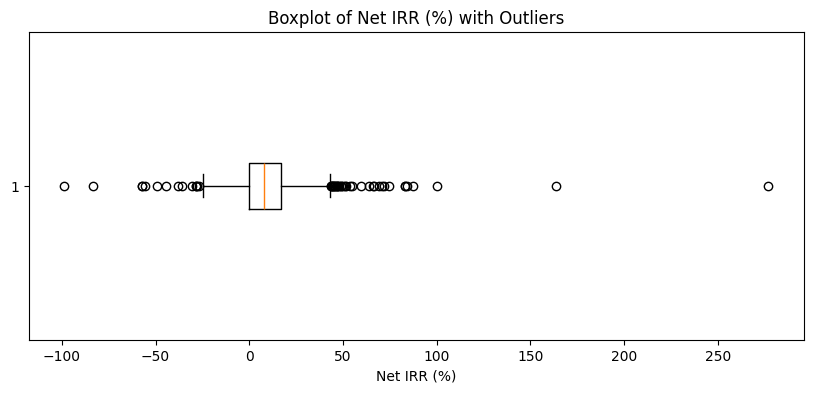

IQR range: [-34.67, 51.60]
Number of outliers: 26 / 822


In [ ]:
# Import essential libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 8: Remove outliers in target using IQR
original_count = len(df)
Q1 = df['target1'].quantile(0.25)
Q3 = df['target1'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Plot boxplot
plt.figure(figsize=(10, 4))
plt.boxplot(df['target1'], vert=False)
plt.title('Boxplot of Net IRR (%) with Outliers')
plt.xlabel('Net IRR (%)')
plt.show()

# Count and print outliers
outlier_mask = (df['target1'] < lower_bound) | (df['target1'] > upper_bound)
outlier_count = outlier_mask.sum()
print(f"IQR range: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Number of outliers: {outlier_count} / {original_count}")

# Remove outliers
df = df[~outlier_mask]

## 3.2 PCA (Principal Component Analysis)

Moshu's Note:

- Each PC is a linear combination of the original variables (columns in the dataset), and the coefficients are called loadings.

- PCs are orthogonal (independent) to each other, meaning there is no correlation between them.

- PCA ranks components by how much variance they capture. The first few PCs capture the most important patterns in the data.

- We typically select the top PCs that together explain a large portion of total variance (e.g., 95%) to reduce dimensionality.

- Within each PC, the absolute value of a variable’s loading reflects its contribution to that component. The larger the value, the more impact that variable has on the PC.

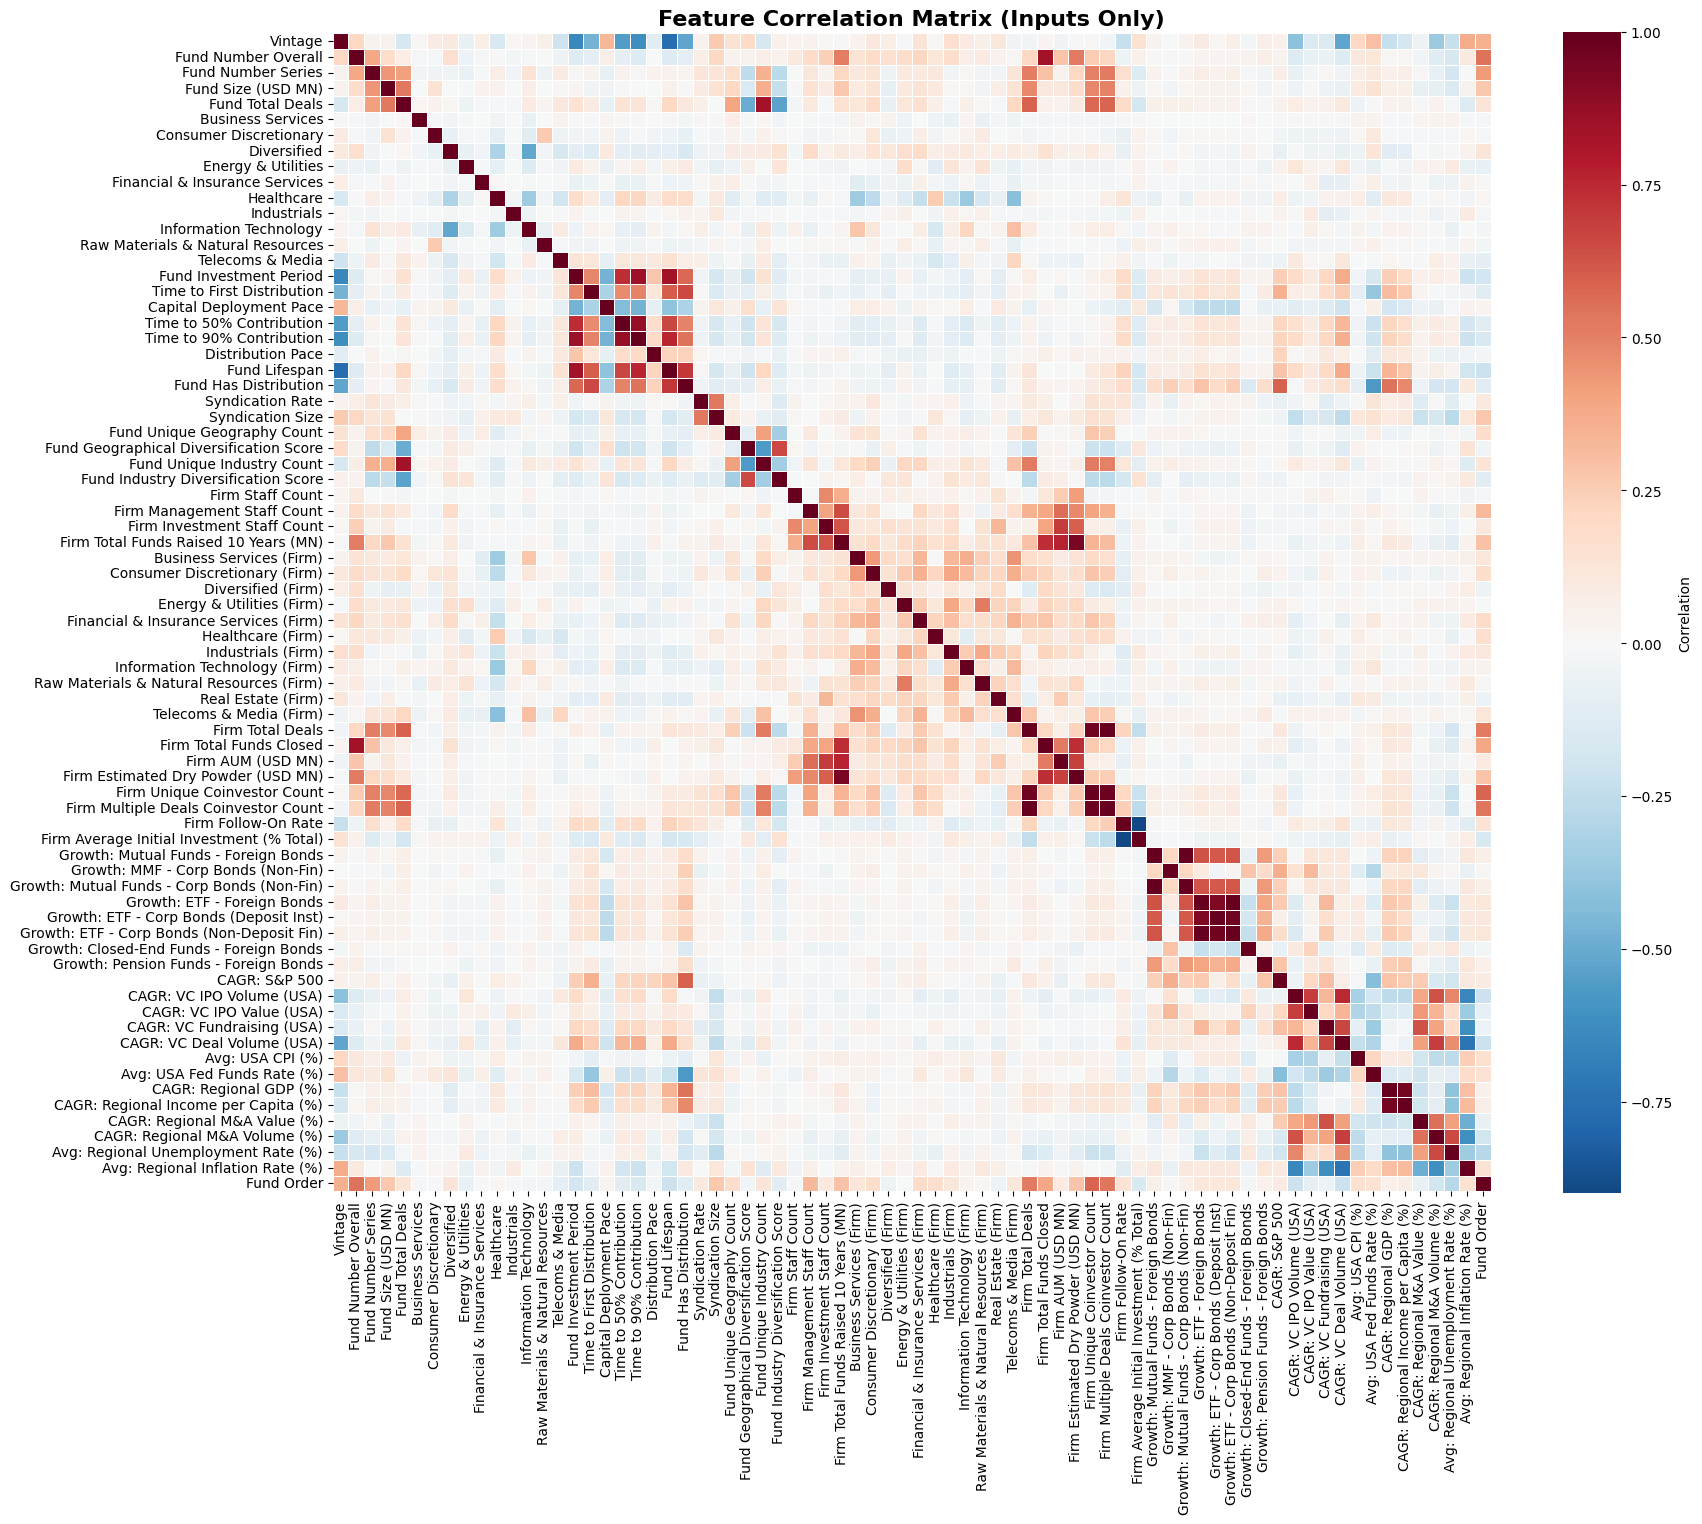

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Identify target columns
target_cols = ['target1', 'target2', 'target3', 'target4']

# Step 2: Select numeric input features only (excluding targets)
numeric_df = df.select_dtypes(include='number')
features_only = numeric_df.drop(columns=target_cols, errors='ignore')

# Step 3: Calculate correlation matrix
corr_matrix = features_only.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(
    corr_matrix,
    cmap='RdBu_r',
    center=0,
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={'label': 'Correlation'},
    annot=False,
    xticklabels=True,
    yticklabels=True
)

plt.title("Feature Correlation Matrix (Inputs Only)", fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

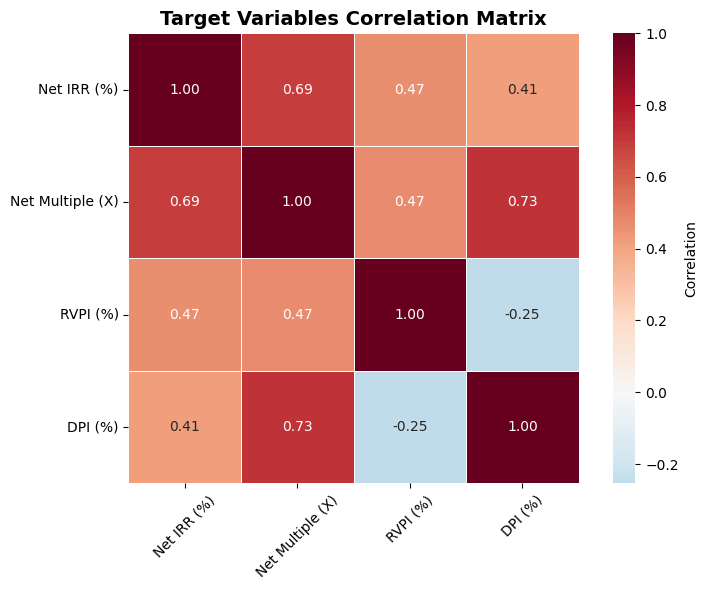

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Map back to real names
target_rename_map = {
    'target1': 'Net IRR (%)',
    'target2': 'Net Multiple (X)',
    'target3': 'RVPI (%)',
    'target4': 'DPI (%)'
}

# Step 2: Select the targets
target_cols = list(target_rename_map.keys())
targets_df = df[target_cols].copy()

# Step 3: Rename for plotting
targets_df = targets_df.rename(columns=target_rename_map)

# Step 4: Correlation matrix
corr_matrix_targets = targets_df.corr()

# Step 5: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix_targets,
    cmap='RdBu_r',
    center=0,
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={'label': 'Correlation'},
    annot=True,    # Show correlation values
    fmt=".2f",
    xticklabels=True,
    yticklabels=True
)

plt.title("Target Variables Correlation Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from google.colab import drive

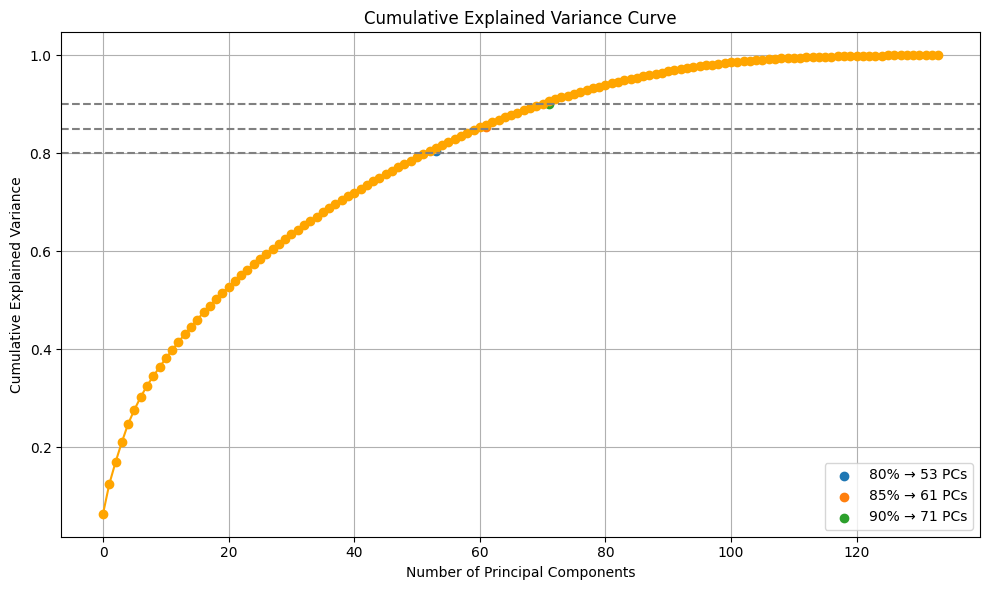

Number of components needed to reach thresholds: {'80%': np.int64(53), '85%': np.int64(61), '90%': np.int64(71)}


In [ ]:
# Fill missing values with column mean before PCA
features_filled = features_cleaned.fillna(features_cleaned.mean())

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_filled)

# Step 9: Perform PCA
pca = PCA()
pca.fit(features_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Calculate number of components to reach variance thresholds
thresholds = [0.80, 0.85, 0.90]
components_needed = {f"{int(t*100)}%": np.argmax(cumulative_var >= t) + 1 for t in thresholds}

# Step 10: Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_var, marker='o', color='orange')

for t in thresholds:
    n = components_needed[f"{int(t*100)}%"]
    plt.axhline(y=t, linestyle='--', color='gray')
    plt.scatter(n, cumulative_var[n-1], label=f"{int(t*100)}% → {n} PCs")

plt.title("Cumulative Explained Variance Curve")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print("Number of components needed to reach thresholds:", components_needed)

In [ ]:
# Choose number of components to explain 85% variance
n_components = 61  # Based on the previous cumulative explained variance chart

# Create DataFrame of loadings for all components (i.e., contribution of each original feature to each PC)
loadings = pd.DataFrame(
    pca.components_[:n_components].T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=features_filled.columns  # Use filled data column names
)

# Display top 3 contributing variables for top 10 principal components
for i in range(10):
    pc = f'PC{i+1}'
    print(f"\n🔹 {pc} - Top 5 contributing variables:")
    print(loadings[pc].abs().sort_values(ascending=False).head(5))


🔹 PC1 - Top 5 contributing variables:
Firm Unique Coinvestor Count             0.248611
Firm Multiple Deals Coinvestor Count     0.245538
Firm Total Deals                         0.238652
Fund Total Deals                         0.191974
Firm Total Funds Raised 10 Years (MN)    0.183500
Name: PC1, dtype: float64

🔹 PC2 - Top 5 contributing variables:
Vintage                     0.242585
Time to 90% Contribution    0.240897
Fund Lifespan               0.239093
Fund Investment Period      0.231798
Time to 50% Contribution    0.224895
Name: PC2, dtype: float64

🔹 PC3 - Top 5 contributing variables:
Firm AUM (USD MN)                        0.212300
Fund Region Focus_North America          0.202407
Firm Listed_True                         0.201333
Firm Total Funds Raised 10 Years (MN)    0.198000
Firm Main Strategy_Buyout                0.197247
Name: PC3, dtype: float64

🔹 PC4 - Top 5 contributing variables:
Growth: ETF - Foreign Bonds                   0.287197
Growth: ETF - Corp Bonds (

Here is the further analysis to be shown in finall paper.

The cumulative explained variance curve is relatively smooth, suggesting that the dataset does not contain a few dominant principal components. As a result, a larger number of components are required to capture sufficient variance, which increases the model complexity and may reduce interpretability.



## 3.3 K-means Clustering

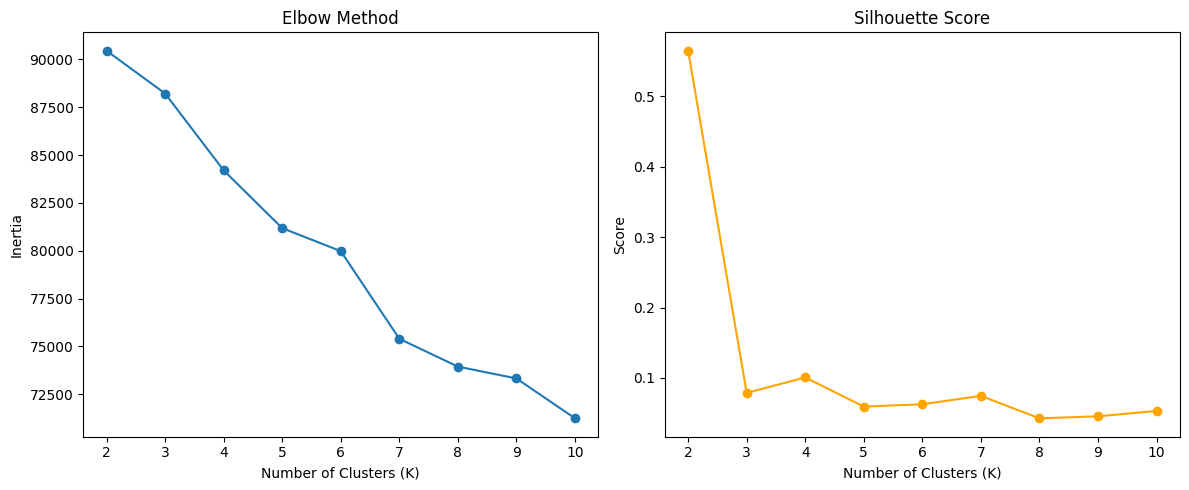

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Step 0: Ensure missing values are handled
features_filled = features_cleaned.fillna(features_cleaned.mean())  # Ensure no NaNs

# Step 1: Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_filled)

# Step 2: Fit PCA with selected number of components
pca = PCA(n_components=61)
pca_data = pca.fit_transform(features_scaled)

# Step 3: Range of K values to try
k_range = range(2, 11)
inertia = []
silhouette_scores = []

# Step 4: Fit KMeans for each K and collect metrics
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_data, kmeans.labels_))

# Step 5: Plot the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")

plt.tight_layout()
plt.show()

In [ ]:
!pip install umap-learn

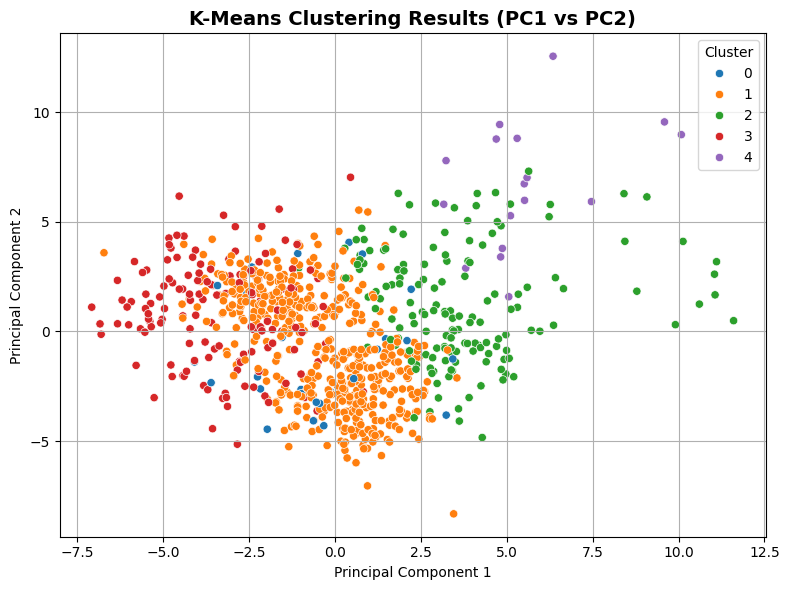

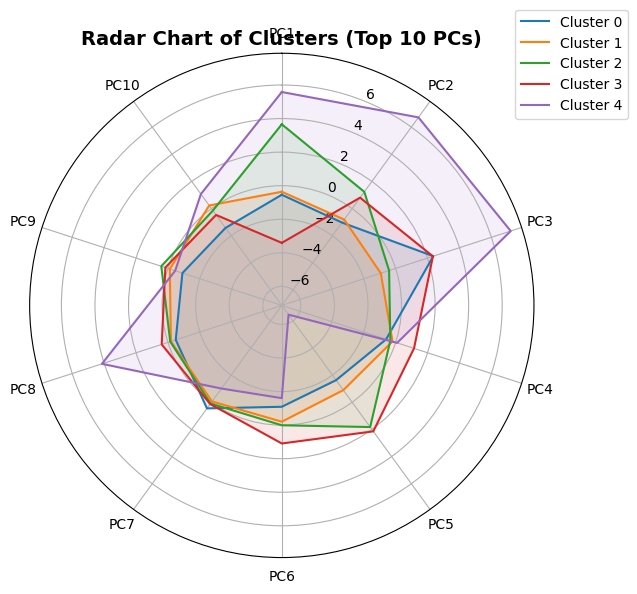

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


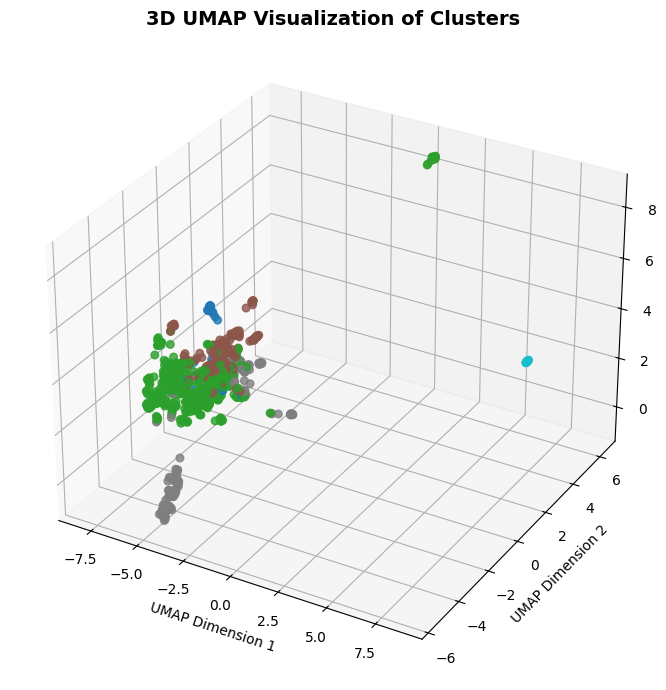

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Standardize the features and apply PCA
features_filled = features_cleaned.fillna(features_cleaned.mean())

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_filled)

# Perform PCA to reduce dimensionality (keep 61 components, can adjust if needed)
pca = PCA(n_components=61)
pca_data = pca.fit_transform(features_scaled)

# Step 2: Apply KMeans clustering with K=5
kmeans_final = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans_final.fit_predict(pca_data)

# Step 3: Create a DataFrame with top principal components and cluster labels
df_pca = pd.DataFrame(pca_data[:, :10], columns=[f'PC{i+1}' for i in range(10)])
df_pca['Cluster'] = cluster_labels

# Step 4: 2D Scatter Plot of Clusters (using PC1 vs PC2)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("K-Means Clustering Results (PC1 vs PC2)", fontsize=14, fontweight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Radar Plot to show average PC values for each cluster
# Compute the mean of the first 10 PCs per cluster
cluster_means = df_pca.groupby('Cluster').mean()

# Radar chart setup
labels = [f'PC{i+1}' for i in range(10)]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart loop

# Plot radar chart
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
for idx in cluster_means.index:
    values = cluster_means.loc[idx].tolist()
    values += values[:1]  # Close the shape
    ax.plot(angles, values, label=f'Cluster {idx}')
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar Chart of Clusters (Top 10 PCs)", fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

# Step 6: 3D UMAP Visualization of Clusters
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = umap_3d.fit_transform(pca_data)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
    c=df_pca['Cluster'], cmap='tab10', s=30, alpha=0.8
)

ax.set_title('3D UMAP Visualization of Clusters', fontsize=14, fontweight='bold')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
plt.tight_layout()
plt.show()

In [ ]:
# Fit KMeans with chosen K
kmeans_final = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans_final.fit_predict(pca_data)

# Add cluster labels to your DataFrame
df_pca['Cluster'] = cluster_labels

# Check distribution
print(df_pca['Cluster'].value_counts())


Cluster
1    482
2    156
3    140
0     27
4     17
Name: count, dtype: int64


In [ ]:
cluster_means
# Make sure you have this structure:
# df_pca = DataFrame with PC1, PC2, ..., PCn and a 'Cluster' column

# 1. Select PC columns
pc_columns = [col for col in cluster_means.columns if col.startswith('PC')]

# 2. Group by cluster and take the mean of each PC
cluster_pc_loadings = cluster_means.groupby('Cluster')[pc_columns].mean()

# 3. Print the table
print(cluster_pc_loadings.round(3))


           PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9   PC10
Cluster                                                                      
0       -0.541 -1.034  2.360 -0.597 -1.629 -1.094  0.452 -0.490 -0.906 -1.427
1       -0.361 -0.810 -0.931 -0.196 -0.895 -0.203 -0.058 -0.185 -0.116  0.226
2        3.659  1.230 -0.411 -0.334  1.827  0.009  0.094 -0.143  0.417 -0.146
3       -3.407  0.801  2.334  1.151  2.143  1.094  0.130  0.390  0.164 -0.470
4        5.583  6.717  7.210  0.092 -6.452 -1.608 -1.011  4.137 -0.452  1.068


**=== K-Means Clustering Summary ===**

We used PCA-reduced data (retaining 85% of variance) as input for K-Means to reduce noise and dimensionality.

To determine the optimal number of clusters (K), we applied both the Elbow Method and Silhouette Score.

The Elbow plot showed a flattening around K=4, and Silhouette Score also supported K=4 as a reasonable choice.

We then fit the KMeans model with K=4 and labeled each sample accordingly.

These cluster labels will be used later as an additional feature in the XGBoost model.


# 4. Supervised Learning Model

### Import Required Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim


### Data Preparation

In [ ]:
# Step 1: Load data
df = FINAL_DATA.copy()
#df = pd.read_excel("FINAL_DATA.xlsx")

# Step 2: Drop ID and name-related columns
id_cols = ['index', 'Fund ID', 'Firm ID', 'Fund Name', 'Firm Name']
df = df.drop(columns=id_cols, errors='ignore')

# Step 3: Drop date-related columns
date_cols = [
    'Final Close Date',
    'First Call Date',
    'Final Distribution Date',
    'Earliest Transaction Date',
    'Latest Transaction Date'
]
df = df.drop(columns=date_cols, errors='ignore')

# Step 4: Drop constant-value columns
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
if constant_cols:
    print(f"Dropped {len(constant_cols)} constant-value column(s):")
    for col in constant_cols:
        print(f"- {col}: constant value = {df[col].unique()[0]}")
else:
    print("No constant-value columns found.")
df = df.drop(columns=constant_cols, errors='ignore')

# Step 5: Rename target columns and drop unused performance metrics
target_cols = {
    'Net IRR (%)': 'target1',
    'Net Multiple (X)': 'target2',
    'RVPI (%)': 'target3',
    'DPI (%)': 'target4'
}
performance_cols = ['Called (%)']

df = df.drop(columns=performance_cols, errors='ignore')
existing_targets = [col for col in target_cols if col in df.columns]
df = df.rename(columns={col: target_cols[col] for col in existing_targets})


# Step 6: Drop high-cardinality categorical variables
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
high_card_cols = [col for col in categorical_cols if df[col].nunique() > 20]

print("Dropped high-cardinality categorical variables (> 20 unique categories):")
for col in high_card_cols:
    print(f"- {col}: {df[col].nunique()} unique values")

df = df.drop(columns=high_card_cols, errors='ignore')

# Step 7: One-hot encode remaining categorical variables
remaining_cat_cols = [col for col in categorical_cols if col not in high_card_cols]
df = pd.get_dummies(df, columns=remaining_cat_cols, drop_first=True)


NameError: name 'FINAL_DATA' is not defined

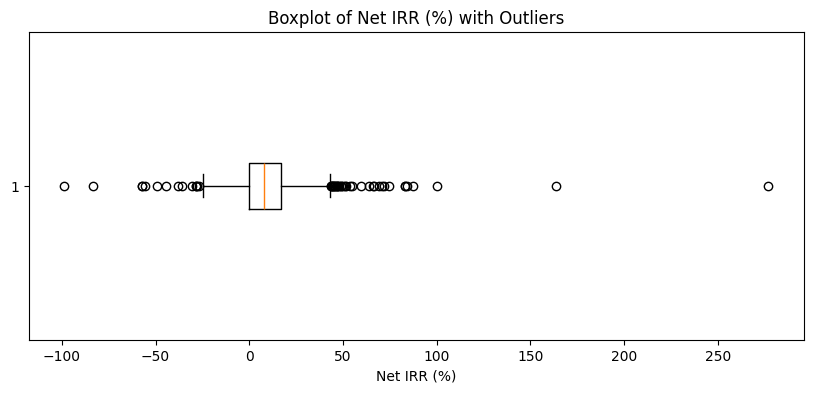

IQR range: [-34.63, 51.55]
Number of outliers: 26 / 823


In [ ]:
# Step 8: Remove outliers in target using IQR
original_count = len(df)
Q1 = df['target1'].quantile(0.25)
Q3 = df['target1'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Plot boxplot
plt.figure(figsize=(10, 4))
plt.boxplot(df['target1'], vert=False)
plt.title('Boxplot of Net IRR (%) with Outliers')
plt.xlabel('Net IRR (%)')
plt.show()

# Count and print outliers
outlier_mask = (df['target1'] < lower_bound) | (df['target1'] > upper_bound)
outlier_count = outlier_mask.sum()
print(f"IQR range: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Number of outliers: {outlier_count} / {original_count}")

# Remove outliers
df = df[~outlier_mask]

### 4.1 Multivariable Linear Regression on IRR

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Prepare for modeling target1
X = df.drop(columns=list(target_cols.values()), errors='ignore')
y = df['target1']

# Step 2: Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 3: Standardize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_imputed)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Step 4: Add constant for intercept
X_scaled_const = sm.add_constant(X_scaled)

# Step 5: Fit OLS regression model
ols_model = sm.OLS(y_scaled, X_scaled_const).fit()

# Step 6: Output full statistical summary
print(ols_model.summary())

# Step 7: Predict and inverse transform
y_pred_scaled = ols_model.predict(X_scaled_const)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Step 8: Evaluation
print("\nModel Evaluation (Original Scale):")
print("R-squared:", round(r2_score(y, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y, y_pred)), 4))



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     2.708
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           7.89e-17
Time:                        01:24:42   Log-Likelihood:                -956.71
No. Observations:                 797   AIC:                             2183.
Df Residuals:                     662   BIC:                             2815.
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.338e-15      0.031  -7.49e-14      1.0

### 4.2 Multivariable Linear Regression with Marginal Impact Analysis

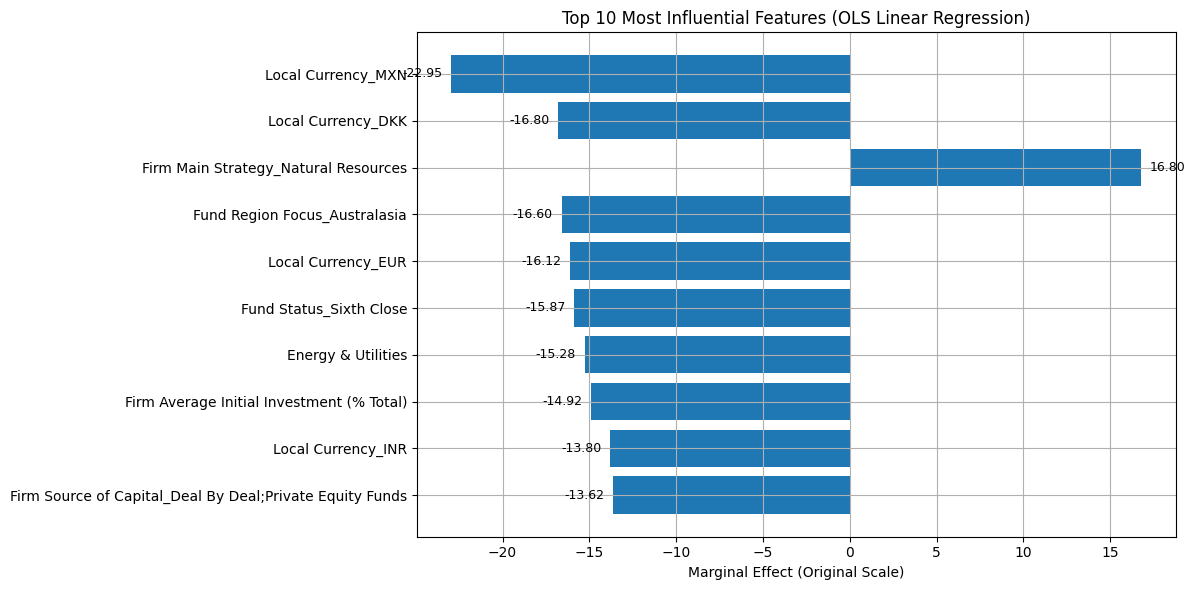

In [ ]:
# Step 9: Recover coefficients to original scale (Marginal Effect)
beta_standardized = ols_model.params[1:]  # skip intercept
std_y = scaler_y.scale_[0]
std_X = scaler_X.scale_
beta_original = beta_standardized * (std_y / std_X)

# Create DataFrame for coefficients
beta_df = pd.DataFrame({
    'Feature': X.columns,
    'Beta_Standardized': beta_standardized,
    'Beta_OriginalScale': beta_original
}).sort_values(by='Beta_OriginalScale', key=np.abs, ascending=False)

# Step 10: Plot top N influential features (Marginal Effect Analysis)
top_n = 10
top_features = beta_df.head(top_n)

plt.figure(figsize=(12, 6))
bars = plt.barh(top_features['Feature'][::-1], top_features['Beta_OriginalScale'][::-1])

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (0.5 if width > 0 else -0.5),
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        va='center',
        ha='left' if width > 0 else 'right',
        fontsize=9
    )

plt.xlabel("Marginal Effect (Original Scale)")
plt.title(f"Top {top_n} Most Influential Features (OLS Linear Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.3.1 Random Forest
Random Forest Regressor + cross-validation + parameter tuning + final model trained on the full dataset


Best parameters selected based on CV:
n_estimators         200.0000
max_depth                 NaN
min_samples_split      2.0000
CV Mean R2             0.2594
CV Std R2              0.0371
CV Mean RMSE          12.2185
CV Std RMSE            0.7156
Name: 16, dtype: float64

Final Model Evaluation on Full Data:
R-squared (Full Data): 0.8989
RMSE (Full Data): 4.5306


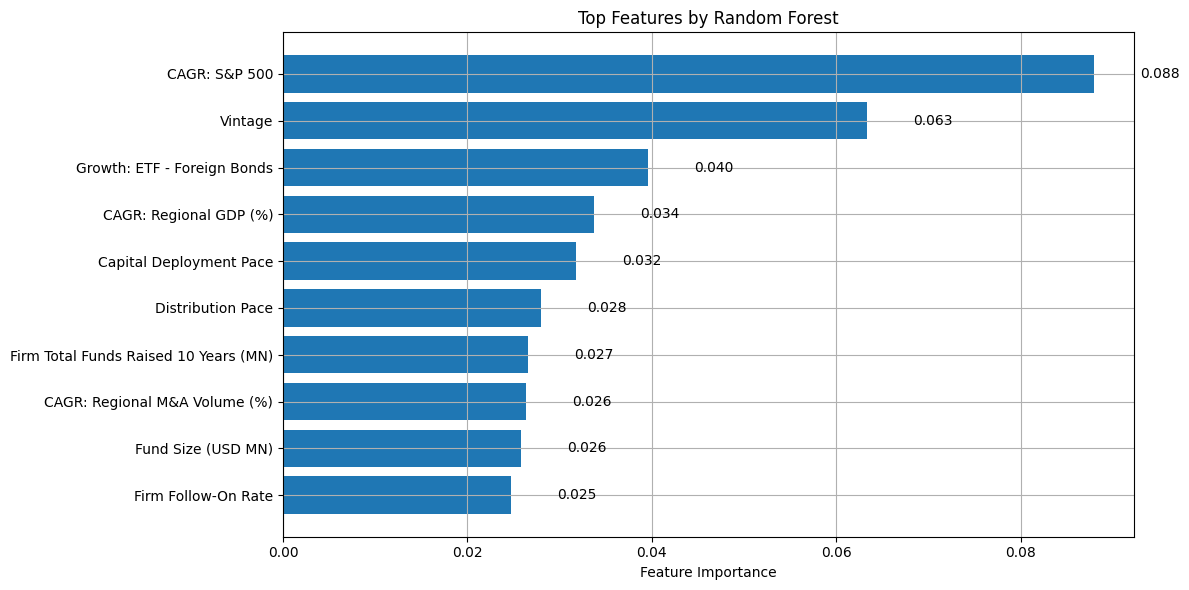

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate, KFold
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


X = df.drop(columns=list(target_cols.values()), errors='ignore')
y = df['target1']

# Step 1: Impute missing values once
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
feature_names = X.columns
y_array = y.values  # just in case y is a pandas Series

# Step 2: Define parameter grid
n_estimators_list = [50, 100, 200]
max_depth_list = [5, 10, None]
min_samples_split_list = [2, 5]

# Step 3: Cross-validation settings
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'r2': make_scorer(r2_score),
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

# Step 4: Perform grid search with cross-validation
results = []

for n_est, max_d, min_split in product(n_estimators_list, max_depth_list, min_samples_split_list):
    rf_model = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=max_d,
        min_samples_split=min_split,
        random_state=42,
        n_jobs=-1
    )
    cv_scores = cross_validate(rf_model, X_imputed, y_array, cv=kf, scoring=scoring)
    results.append({
        'n_estimators': n_est,
        'max_depth': max_d,
        'min_samples_split': min_split,
        'CV Mean R2': round(cv_scores['test_r2'].mean(), 4),
        'CV Std R2': round(cv_scores['test_r2'].std(), 4),
        'CV Mean RMSE': round(-cv_scores['test_rmse'].mean(), 4),
        'CV Std RMSE': round(cv_scores['test_rmse'].std(), 4)
    })

results_df = pd.DataFrame(results)

# Step 5: Select the best parameters (highest CV R²)
best_params = results_df.sort_values(by='CV Mean R2', ascending=False).iloc[0]
print("\nBest parameters selected based on CV:")
print(best_params)

# Step 6: Train final model using full data with best params
final_model = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=None if pd.isnull(best_params['max_depth']) else int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_imputed, y_array)

# Step 7: Evaluate on full data
y_pred_full = final_model.predict(X_imputed)
full_r2 = r2_score(y_array, y_pred_full)
full_rmse = np.sqrt(mean_squared_error(y_array, y_pred_full))

print("\nFinal Model Evaluation on Full Data:")
print(f"R-squared (Full Data): {full_r2:.4f}")
print(f"RMSE (Full Data): {full_rmse:.4f}")

# Step 8: Feature importance visualization
top_n = 10
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1][:top_n]
top_features = [(feature_names[i], importances[i]) for i in indices]

plt.figure(figsize=(12, 6))
bars = plt.barh(range(top_n), [f[1] for f in top_features][::-1])
plt.yticks(range(top_n), [f[0] for f in top_features][::-1])
plt.xlabel("Feature Importance")
plt.title("Top Features by Random Forest")
plt.grid(True)
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}", va='center', ha='left')
plt.tight_layout()
plt.show()


### 4.4.1 XGBoost
XGBoost Regressor + cross-validation + parameter tuning + final model trained on the full dataset


Best XGBoost parameters based on CV R²:
n_estimators      500.0000
max_depth           7.0000
learning_rate       0.0100
CV R2 (mean)        0.2872
CV R2 (std)         0.0278
CV RMSE (mean)     11.9628
CV RMSE (std)       0.4526
Name: 24, dtype: float64

Final Model Evaluation on Full Data:
Full Data R²: 0.9597
Full Data RMSE: 2.8632


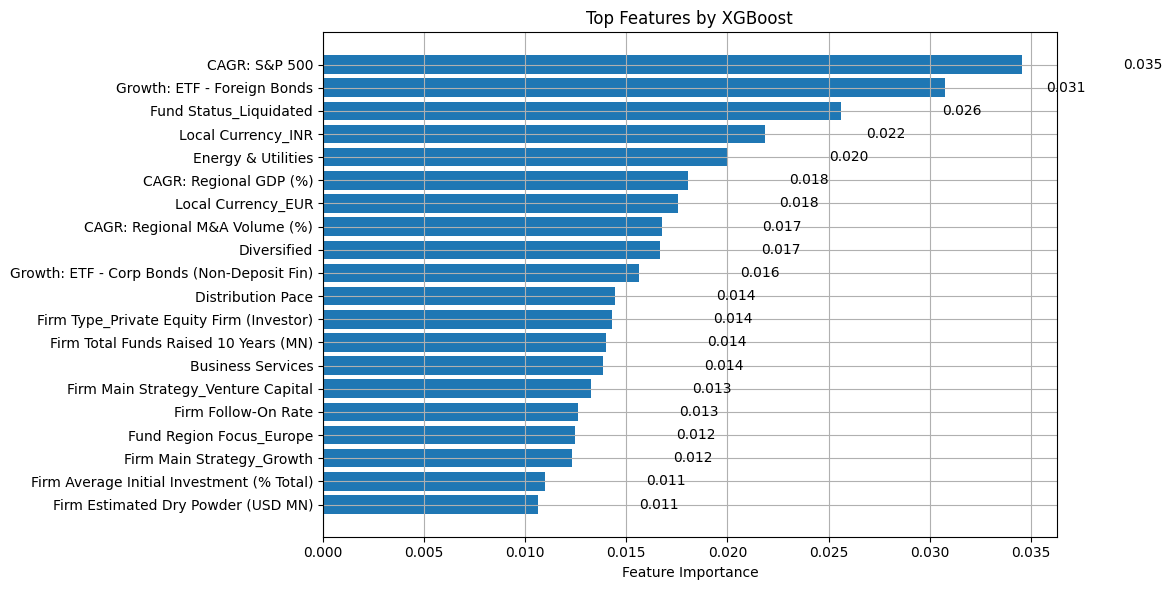

In [ ]:
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate, KFold
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare input data
X = df.drop(columns=list(target_cols.values()), errors='ignore')
y = df['target1']

# Step 2: Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
feature_names = X.columns

# Step 3: Define custom RMSE scorer
scoring = {
    'r2': make_scorer(r2_score),
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Define parameter grid
n_estimators_list = [100, 300, 500]
max_depth_list = [3, 5, 7]
learning_rate_list = [0.01, 0.05, 0.1]

# Step 5: Hyperparameter tuning with cross-validation
results = []

for n_est, max_d, lr in product(n_estimators_list, max_depth_list, learning_rate_list):
    model = XGBRegressor(
        n_estimators=n_est,
        max_depth=max_d,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    cv_scores = cross_validate(model, X_imputed, y, cv=kf, scoring=scoring, return_train_score=False)

    results.append({
        'n_estimators': n_est,
        'max_depth': max_d,
        'learning_rate': lr,
        'CV R2 (mean)': round(cv_scores['test_r2'].mean(), 4),
        'CV R2 (std)': round(cv_scores['test_r2'].std(), 4),
        'CV RMSE (mean)': round(-cv_scores['test_rmse'].mean(), 4),
        'CV RMSE (std)': round(cv_scores['test_rmse'].std(), 4)
    })

results_df = pd.DataFrame(results)

# Step 6: Select best model based on highest CV R2
best_params = results_df.sort_values(by='CV R2 (mean)', ascending=False).iloc[0]
print("\nBest XGBoost parameters based on CV R²:")
print(best_params)

# Step 7: Train final XGBoost model on full data
final_model = XGBRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=float(best_params['learning_rate']),
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
final_model.fit(X_imputed, y)

# Step 8: Evaluate on full data
y_pred = final_model.predict(X_imputed)
full_r2 = r2_score(y, y_pred)
full_rmse = np.sqrt(mean_squared_error(y, y_pred))

print("\nFinal Model Evaluation on Full Data:")
print(f"Full Data R²: {full_r2:.4f}")
print(f"Full Data RMSE: {full_rmse:.4f}")

# Step 9: Feature importance plot
top_n = 20
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1][:top_n]
top_features = [(feature_names[i], importances[i]) for i in indices]

plt.figure(figsize=(12, 6))
bars = plt.barh(range(top_n), [f[1] for f in top_features][::-1])
plt.yticks(range(top_n), [f[0] for f in top_features][::-1])
plt.xlabel("Feature Importance")
plt.title("Top Features by XGBoost")
plt.grid(True)
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}", va='center', ha='left')
plt.tight_layout()
plt.show()


results_all = {
    'model': final_model,
    'importance_df': pd.DataFrame({
        'Feature': feature_names,
        'Importance': final_model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True),
    'r2_full': full_r2,
    'rmse_full': full_rmse
}


### 4.4.4 SHAP Value Analysis

 98%|===================| 779/796 [00:41<00:00]       

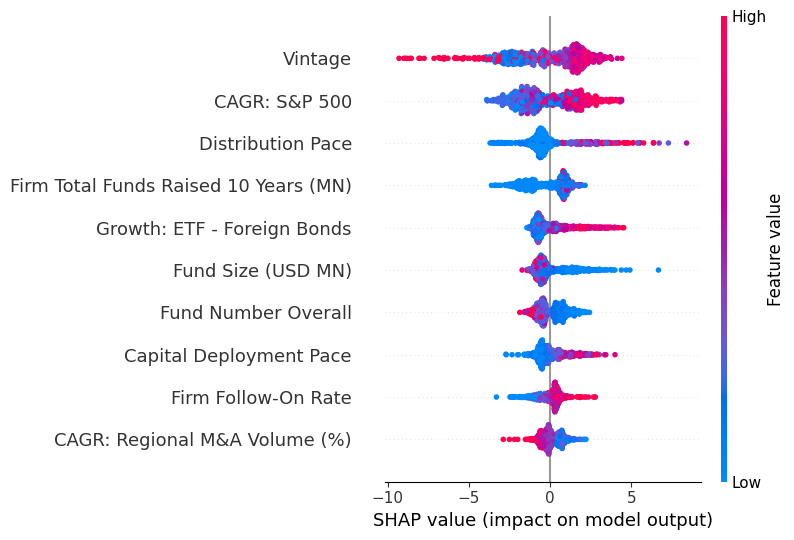

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Initialize SHAP Explainer on full (imputed) dataset
explainer = shap.Explainer(final_model, X_imputed, feature_names=X.columns)

# === Step 2: Compute SHAP values on full dataset
shap_values = explainer(X_imputed)

# === Step 3: Global SHAP summary plot (Top 20 features)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_imputed, feature_names=X.columns, max_display=10, show=True)


# Compute SHAP values for Base Model
explainer_base = shap.TreeExplainer(final_model)
shap_values_base = explainer_base.shap_values(X_imputed)




# 5. Supplementary Analysis

## 5.1. Supp Model 1 - XGBoost Only Liquidated Funds on IRR

XGBoost (Liquidated) - Full R²: 0.9282
XGBoost (Liquidated) - Full RMSE: 3.1558


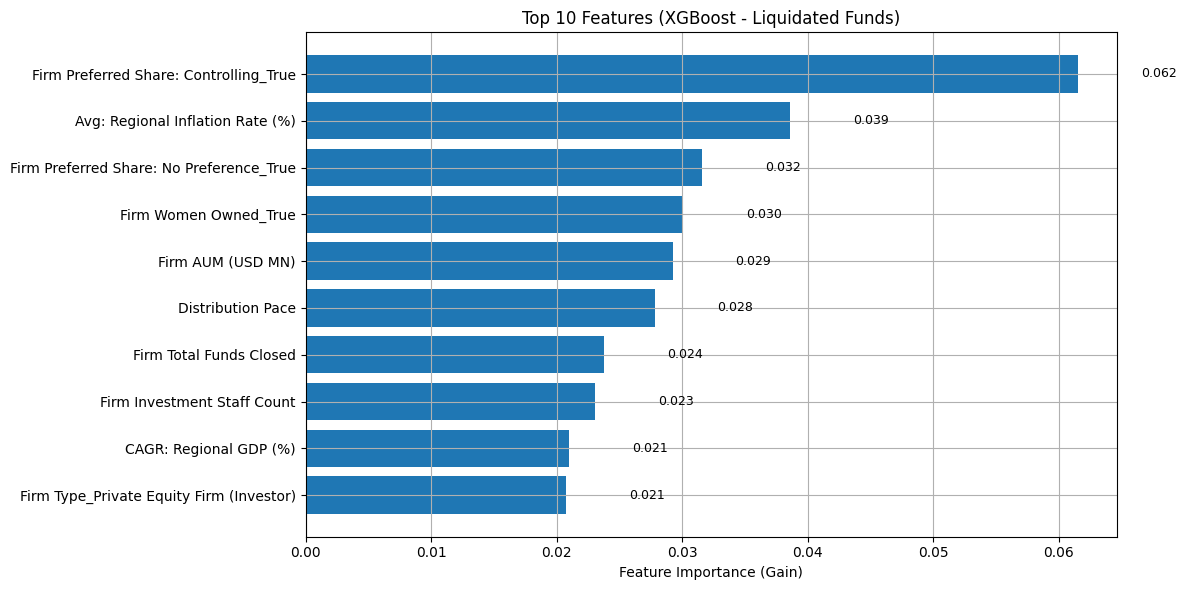

In [ ]:
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and filter only Liquidated funds
df_Liquidated = df[df['Fund Status_Liquidated'] == 1].copy()

# Step 2: Drop all target columns except target1
X_liq = df_Liquidated.drop(columns=list(target_cols.values()), errors='ignore')
y_liq = df_Liquidated['target1']

# Step 3: Impute missing values on full liquidated dataset
imputer = SimpleImputer(strategy='mean')
X_liq_imputed = imputer.fit_transform(X_liq)

# Step 4: Define XGBoost model using best parameters (manually entered)
Liquidated_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Step 5: Train on full liquidated data
Liquidated_model.fit(X_liq_imputed, y_liq)

# Step 6: Evaluate on full data
y_pred_liq = Liquidated_model.predict(X_liq_imputed)
r2_liq = r2_score(y_liq, y_pred_liq)
rmse_liq = np.sqrt(mean_squared_error(y_liq, y_pred_liq))

print(f"XGBoost (Liquidated) - Full R²: {r2_liq:.4f}")
print(f"XGBoost (Liquidated) - Full RMSE: {rmse_liq:.4f}")

# Step 7: Extract feature importance
importance_df_liq = pd.DataFrame({
    'Feature': X_liq.columns,
    'Importance': Liquidated_model.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Step 8: Plot top features
top_n = 10
top_features_liq = importance_df_liq.head(top_n)

plt.figure(figsize=(12, 6))
bars = plt.barh(top_features_liq['Feature'][::-1], top_features_liq['Importance'][::-1])
plt.xlabel("Feature Importance (Gain)")
plt.title(f"Top {top_n} Features (XGBoost - Liquidated Funds)")
plt.grid(True)

# Add numeric labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# Step 9: Store result
results_liquidated = {
    'model': Liquidated_model,
    'importance_df': importance_df_liq,
    'r2_full': r2_liq,
    'rmse_full': rmse_liq
}

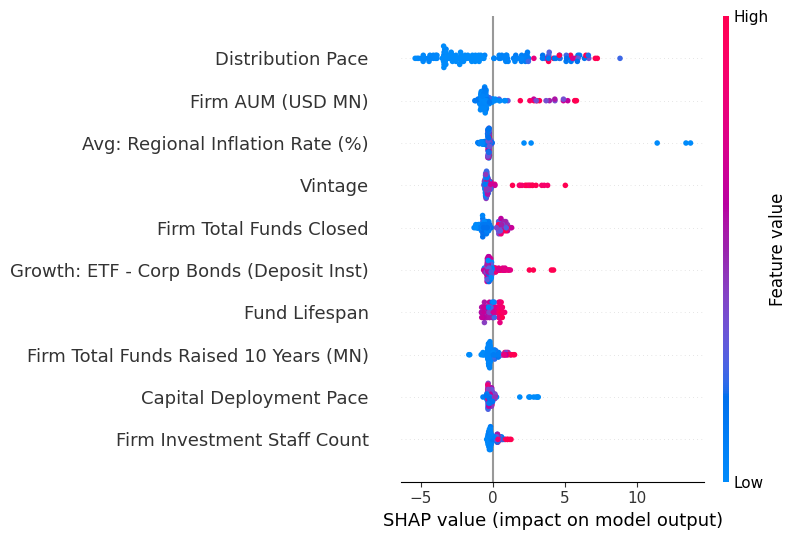

In [ ]:
# === Step 10: SHAP analysis for Liquidated Model ===

# Initialize TreeExplainer
explainer_liq = shap.TreeExplainer(results_liquidated['model'])

# Compute SHAP values
shap_values_liq = explainer_liq.shap_values(X_liq_imputed)

# === Step 11: SHAP summary plot (Top 20 features) ===
plt.figure(figsize=(15, 6))
shap.summary_plot(shap_values_liq, X_liq_imputed, feature_names=X_liq.columns, max_display=10, show=True)

### 5.2. Comparison between All Funds and Liquidated Funds

In [ ]:
import shap
import pandas as pd

# 1) Compute SHAP values (you already have these)
explainer_base = shap.TreeExplainer(results_all['model'])
shap_values_base = explainer_base.shap_values(X)

explainer_liq = shap.TreeExplainer(results_liquidated['model'])
shap_values_liq = explainer_liq.shap_values(X_liq)

# 2) Build SHAP DataFrames
shap_df_base = pd.DataFrame(shap_values_base, columns=X.columns)
shap_df_liq  = pd.DataFrame(shap_values_liq,  columns=X_liq.columns)

# 3) Compute mean *absolute* SHAP
mean_abs_shap_base = shap_df_base.abs().mean().sort_values(ascending=False)
mean_abs_shap_liq  = shap_df_liq.abs().mean().sort_values(ascending=False)

# 4) Select top N by mean abs SHAP
top_n = 10
top_base = (
    mean_abs_shap_base
    .head(top_n)
    .reset_index()
    .rename(columns={'index':'Feature', 0:'MeanAbs_SHAP_Base'})
)
top_liq = (
    mean_abs_shap_liq
    .head(top_n)
    .reset_index()
    .rename(columns={'index':'Feature', 0:'MeanAbs_SHAP_Liquidated'})
)

# 5) Merge and flag
merged = pd.merge(top_base, top_liq, on='Feature', how='outer').fillna(0)

only_base = merged[
    (merged.MeanAbs_SHAP_Base    > 0) &
    (merged.MeanAbs_SHAP_Liquidated == 0)
]

only_liq = merged[
    (merged.MeanAbs_SHAP_Base    == 0) &
    (merged.MeanAbs_SHAP_Liquidated > 0)
]

both = merged[
    (merged.MeanAbs_SHAP_Base    > 0) &
    (merged.MeanAbs_SHAP_Liquidated > 0)
]

# 6) Sort the output tables
only_base = only_base.sort_values('MeanAbs_SHAP_Base', ascending=False)
only_liq  = only_liq.sort_values('MeanAbs_SHAP_Liquidated', ascending=False)
both      = both.sort_values(
    ['MeanAbs_SHAP_Base', 'MeanAbs_SHAP_Liquidated'],
    ascending=[False, False]
)

# 7) Display sorted results
print("🟦 Base-only by MeanAbs SHAP (sorted)")
display(only_base)

print("\n🟥 Liquidated-only by MeanAbs SHAP (sorted)")
display(only_liq)

print("\n🟪 In both models’ top-10 by MeanAbs SHAP (sorted)")
display(both)

🟦 Base-only by MeanAbs SHAP (sorted)


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Liquidated
2,CAGR: S&P 500,1.847642,0.0
14,Growth: ETF - Foreign Bonds,0.949670,0.0
12,Fund Size (USD MN),0.808385,0.0
11,Fund Number Overall,0.622525,0.0
6,Firm Follow-On Rate,0.536875,0.0
1,CAGR: Regional M&A Volume (%),0.515145,0.0



🟥 Liquidated-only by MeanAbs SHAP (sorted)


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Liquidated
5,Firm AUM (USD MN),0.0,1.010233
0,Avg: Regional Inflation Rate (%),0.0,0.676019
8,Firm Total Funds Closed,0.0,0.647345
13,Growth: ETF - Corp Bonds (Deposit Inst),0.0,0.416714
10,Fund Lifespan,0.0,0.394272
7,Firm Investment Staff Count,0.0,0.294457



🟪 In both models’ top-10 by MeanAbs SHAP (sorted)


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Liquidated
15,Vintage,1.896311,0.660962
4,Distribution Pace,1.118354,3.202529
9,Firm Total Funds Raised 10 Years (MN),0.993887,0.376072
3,Capital Deployment Pace,0.679743,0.339613


## 5.2. Supp Model 2 - Multiple as Target Variable

### 5.2.1. Modelling


XGBoost (target2) - Full R²: 0.8068
XGBoost (target2) - Full RMSE: 0.4985


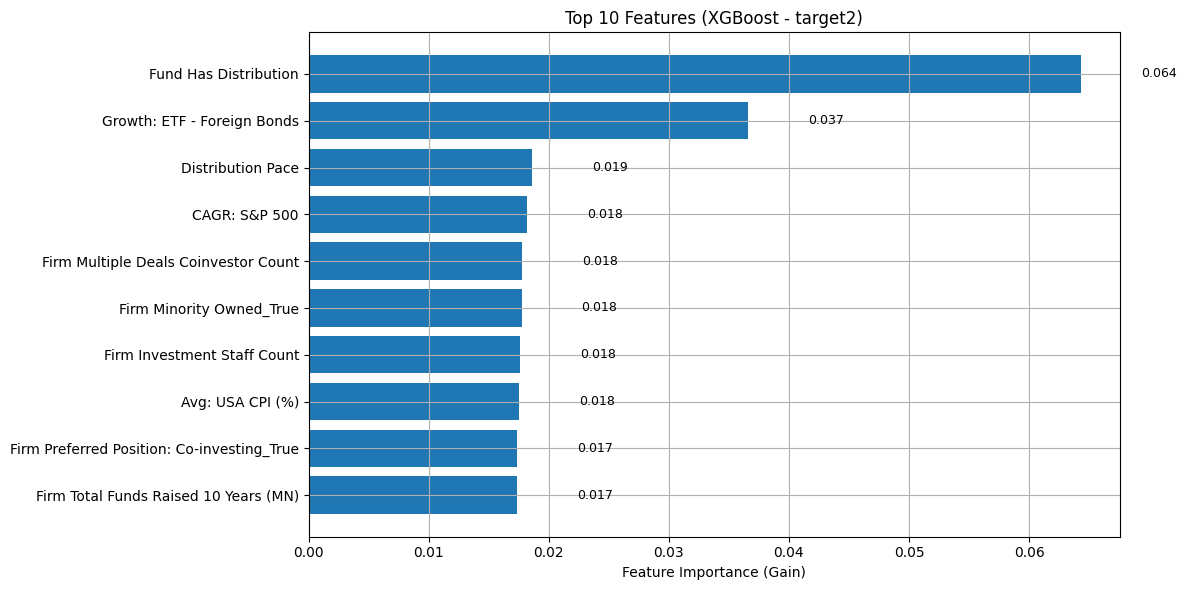

In [ ]:
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Step 1: Prepare input data for target2 ===
X = df.drop(columns=list(target_cols.values()), errors='ignore')
y = df['target2']

# === Step 2: Impute missing values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# === Step 3: Define XGBoost model using best parameters from base model ===
xgb_model_target2 = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# === Step 4: Train the model properly ===
xgb_model_target2.fit(X_imputed, y)

# === Step 5: Predict and evaluate on full data ===
y_pred_target2 = xgb_model_target2.predict(X_imputed)
r2_target2 = r2_score(y, y_pred_target2)
rmse_target2 = np.sqrt(mean_squared_error(y, y_pred_target2))

print(f"\nXGBoost (target2) - Full R²: {r2_target2:.4f}")
print(f"XGBoost (target2) - Full RMSE: {rmse_target2:.4f}")

# === Step 6: Plot top N feature importances ===
feature_names = X.columns
importances_target2 = xgb_model_target2.feature_importances_
indices_target2 = np.argsort(importances_target2)[::-1]
top_n = 10

top_features_target2 = [(feature_names[i], importances_target2[i]) for i in indices_target2[:top_n]]

plt.figure(figsize=(12, 6))
bars = plt.barh(range(top_n), [f[1] for f in top_features_target2][::-1])

plt.yticks(range(top_n), [f[0] for f in top_features_target2][::-1])
plt.xlabel("Feature Importance (Gain)")
plt.title(f"Top {top_n} Features (XGBoost - target2)")
plt.grid(True)

# Add numeric labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va='center',
        ha='left' if width > 0 else 'right',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# === Step 7: Save results for comparison ===
results_target2 = {
    'model': xgb_model_target2,
    'importance_df': pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_target2
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True),
    'r2_full': r2_target2,
    'rmse_full': rmse_target2
}



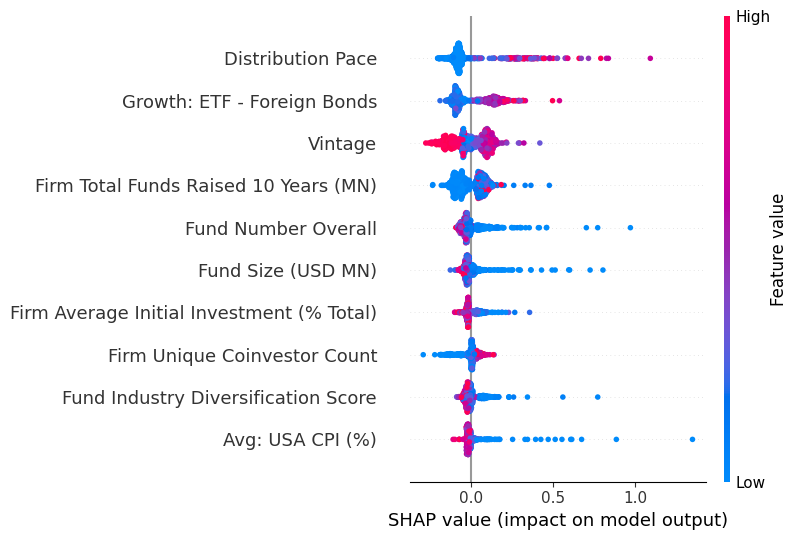

In [ ]:
# === Step 8: SHAP analysis for Target2 Model ===

# Initialize SHAP explainer
explainer_target2 = shap.TreeExplainer(results_target2['model'])

# Compute SHAP values
shap_values_target2 = explainer_target2.shap_values(X_imputed)

# === Step 9: SHAP summary plot (Top 20 features) ===
plt.figure(figsize=(15, 6))
shap.summary_plot(shap_values_target2, X_imputed, feature_names=feature_names, max_display=10, show=True)



### 5.2.2. Comparison between IRR and Multiple as Targets

In [ ]:
import shap
import pandas as pd

# 1. Compute SHAP values (you already have these)
explainer_base    = shap.TreeExplainer(results_all['model'])
shap_values_base  = explainer_base.shap_values(X)
explainer_target2 = shap.TreeExplainer(results_target2['model'])
shap_values_target2 = explainer_target2.shap_values(X)

# 2. Build DataFrames of raw SHAP and compute mean absolute values
shap_df_base       = pd.DataFrame(shap_values_base,      columns=X.columns)
shap_df_target2    = pd.DataFrame(shap_values_target2,   columns=X.columns)

mean_abs_shap_base    = shap_df_base.abs().mean().sort_values(ascending=False)
mean_abs_shap_target2 = shap_df_target2.abs().mean().sort_values(ascending=False)

# 3. Pull out top N by mean absolute SHAP
top_n = 10
top_base_shap = mean_abs_shap_base.head(top_n).reset_index()
top_base_shap.columns = ['Feature', 'MeanAbs_SHAP_Base']

top_target2_shap = mean_abs_shap_target2.head(top_n).reset_index()
top_target2_shap.columns = ['Feature', 'MeanAbs_SHAP_Target2']

# 4. Merge and categorize
merged_shap = pd.merge(top_base_shap,
                       top_target2_shap,
                       on='Feature',
                       how='outer').fillna(0)

only_base    = merged_shap[(merged_shap.MeanAbs_SHAP_Base    > 0) & (merged_shap.MeanAbs_SHAP_Target2 == 0)]
only_target2 = merged_shap[(merged_shap.MeanAbs_SHAP_Base    == 0) & (merged_shap.MeanAbs_SHAP_Target2 > 0)]
both         = merged_shap[(merged_shap.MeanAbs_SHAP_Base    > 0) & (merged_shap.MeanAbs_SHAP_Target2 > 0)]

# 7) Sort each table by its SHAP magnitude
only_base = only_base.sort_values('MeanAbs_SHAP_Base', ascending=False)
only_target2  = only_target2.sort_values('MeanAbs_SHAP_Target2', ascending=False)
both     = both.sort_values(
    ['MeanAbs_SHAP_Base','MeanAbs_SHAP_Target2'],
    ascending=[False, False]
)

# 5. Display your results
print("🟦 Top features by MeanAbs SHAP — Base only")
display(only_base[['Feature','MeanAbs_SHAP_Base']])

print("\n🟥 Top features by MeanAbs SHAP — Target2 only")
display(only_target2[['Feature','MeanAbs_SHAP_Target2']])

print("\n🟪 Top features by MeanAbs SHAP — Both models")
display(both[['Feature','MeanAbs_SHAP_Base','MeanAbs_SHAP_Target2']])


🟦 Top features by MeanAbs SHAP — Base only


,Feature,MeanAbs_SHAP_Base
2,CAGR: S&P 500,1.847642
3,Capital Deployment Pace,0.679743
6,Firm Follow-On Rate,0.536875
1,CAGR: Regional M&A Volume (%),0.515145



🟥 Top features by MeanAbs SHAP — Target2 only


,Feature,MeanAbs_SHAP_Target2
5,Firm Average Initial Investment (% Total),0.031818
8,Firm Unique Coinvestor Count,0.031514
9,Fund Industry Diversification Score,0.031295
0,Avg: USA CPI (%),0.029493



🟪 Top features by MeanAbs SHAP — Both models


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Target2
13,Vintage,1.896311,0.089008
4,Distribution Pace,1.118354,0.127308
7,Firm Total Funds Raised 10 Years (MN),0.993887,0.073548
12,Growth: ETF - Foreign Bonds,0.949670,0.108589
11,Fund Size (USD MN),0.808385,0.035943
10,Fund Number Overall,0.622525,0.052550


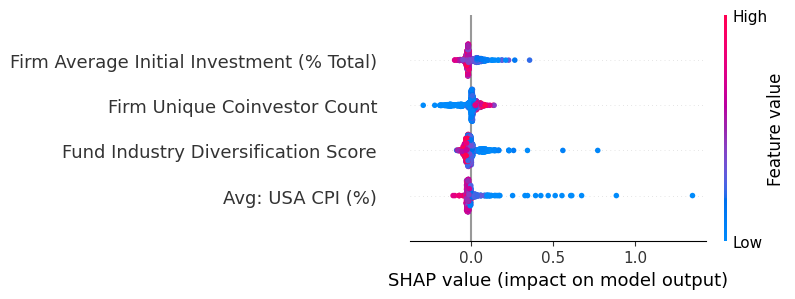

In [ ]:
import shap

# === 1) Net Multiple model: plot SHAP only for features in only_nm ===
feat_only_nm = only_target2['Feature'].tolist()

# get column positions in X_nm
idxs_nm = [X.columns.get_loc(f) for f in feat_only_nm]

# subset the data & SHAP arrays
X_nm_subset         = X[feat_only_nm]
shap_vals_nm_subset = shap_values_target2[:, idxs_nm]

# make the summary plot
shap.summary_plot(
    shap_vals_nm_subset,
    X_nm_subset,
    feature_names=feat_only_nm,
    plot_type="dot",
    show=True
)


## 5.3. Supp Model 3 - DPI as Target Variable

### 5.3.1. Modelling


XGBoost (target3) - Full R²: 0.8151
XGBoost (target3) - Full RMSE: 34.8446


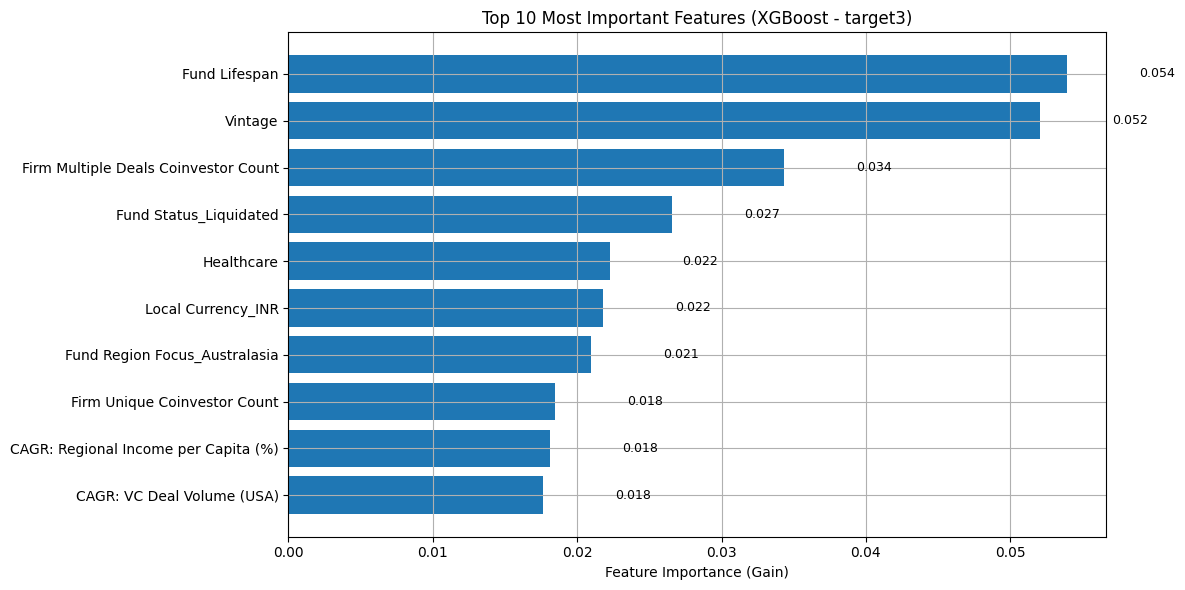

In [ ]:
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Step 1: Prepare input data for target3 ===
X = df.drop(columns=list(target_cols.values()), errors='ignore')
y = df['target3']

# === Step 2: Impute missing values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# === Step 3: Train XGBoost model using best parameters (manual entry)
xgb_model_target3 = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# === Step 4: Fit model
xgb_model_target3.fit(X_imputed, y)

# === Step 5: Predict and evaluate on full data
y_pred_target3 = xgb_model_target3.predict(X_imputed)
r2_target3 = r2_score(y, y_pred_target3)
rmse_target3 = np.sqrt(mean_squared_error(y, y_pred_target3))

print(f"\nXGBoost (target3) - Full R²: {r2_target3:.4f}")
print(f"XGBoost (target3) - Full RMSE: {rmse_target3:.4f}")

# === Step 6: Plot top N feature importances
feature_names = X.columns
importances_target3 = xgb_model_target3.feature_importances_
indices_target3 = np.argsort(importances_target3)[::-1]
top_n = 10

top_features_target3 = [(feature_names[i], importances_target3[i]) for i in indices_target3[:top_n]]

plt.figure(figsize=(12, 6))
bars = plt.barh(range(top_n), [f[1] for f in top_features_target3][::-1])

plt.yticks(range(top_n), [f[0] for f in top_features_target3][::-1])
plt.xlabel("Feature Importance (Gain)")
plt.title(f"Top {top_n} Most Important Features (XGBoost - target3)")
plt.grid(True)

# Add numeric labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va='center',
        ha='left' if width > 0 else 'right',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# === Step 7: Save results for comparison
results_target3 = {
    'model': xgb_model_target3,
    'importance_df': pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_target3
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True),
    'r2_full': r2_target3,
    'rmse_full': rmse_target3
}


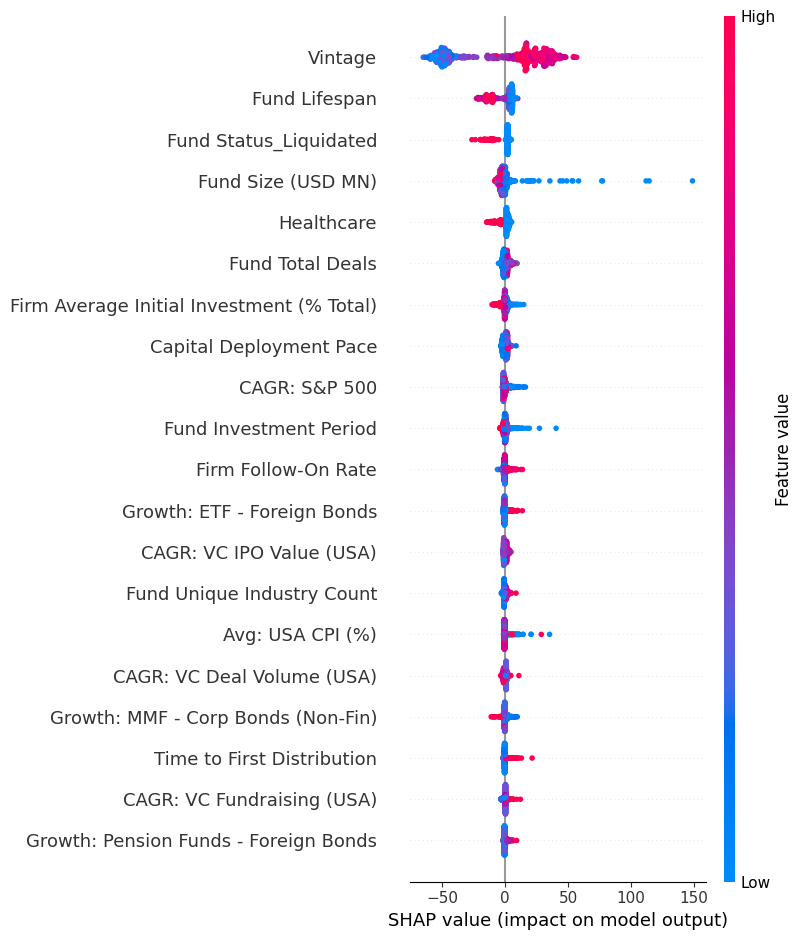

In [ ]:
# === Step 8: SHAP analysis for Target3 Model ===

# Initialize SHAP explainer
explainer_target3 = shap.TreeExplainer(results_target3['model'])

# Compute SHAP values
shap_values_target3 = explainer_target3.shap_values(X_imputed)

# === Step 9: SHAP summary plot (Top 20 features) ===
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_target3, X_imputed, feature_names=feature_names, max_display=20, show=True)


### 5.3.2. Comparison between IRR and DPI as Targets

In [ ]:
import shap
import pandas as pd


# === Step 1: Compute SHAP values with TreeExplainer ===
explainer_base    = shap.TreeExplainer(results_all['model'])
shap_values_base  = explainer_base.shap_values(X)
explainer_target3 = shap.TreeExplainer(results_target3['model'])
shap_values_target3 = explainer_target3.shap_values(X)

# === Step 2: Build SHAP DataFrames ===
shap_df_base    = pd.DataFrame(shap_values_base,    columns=X.columns)
shap_df_target3 = pd.DataFrame(shap_values_target3, columns=X.columns)

# === Step 3: Compute mean *absolute* SHAP per feature ===
mean_abs_base    = shap_df_base.abs().mean().sort_values(ascending=False)
mean_abs_target3 = shap_df_target3.abs().mean().sort_values(ascending=False)

# === Step 4: Take top N by mean abs SHAP ===
top_n = 10
top_base = (
    mean_abs_base
    .head(top_n)
    .reset_index()
    .rename(columns={'index':'Feature', 0:'MeanAbs_SHAP_Base'})
)
top_target3 = (
    mean_abs_target3
    .head(top_n)
    .reset_index()
    .rename(columns={'index':'Feature', 0:'MeanAbs_SHAP_Target3'})
)

# === Step 5: Merge and compute difference vs Base ===
merged_shap = pd.merge(top_base, top_target3, on='Feature', how='outer').fillna(0)
merged_shap['Diff_MeanAbs_SHAP'] = merged_shap['MeanAbs_SHAP_Target3'] - merged_shap['MeanAbs_SHAP_Base']

# === Step 6: Categorize features ===
only_base    = merged_shap[(merged_shap.MeanAbs_SHAP_Base    > 0) & (merged_shap.MeanAbs_SHAP_Target3 == 0)]
only_target3 = merged_shap[(merged_shap.MeanAbs_SHAP_Base    == 0) & (merged_shap.MeanAbs_SHAP_Target3 > 0)]
both         = merged_shap[(merged_shap.MeanAbs_SHAP_Base    > 0) & (merged_shap.MeanAbs_SHAP_Target3 > 0)]

# === Step 7: Sort each table by its SHAP magnitude ===
only_base    = only_base.sort_values('MeanAbs_SHAP_Base',    ascending=False)
only_target3 = only_target3.sort_values('MeanAbs_SHAP_Target3', ascending=False)
both         = both.sort_values(['MeanAbs_SHAP_Base','MeanAbs_SHAP_Target3'], ascending=[False,False])

# === Step 8: Display the sorted results with the difference column ===
print("🟦 Features only in Base top-10 by MeanAbs SHAP:")
display(only_base[['Feature','MeanAbs_SHAP_Base','MeanAbs_SHAP_Target3','Diff_MeanAbs_SHAP']])

print("\n🟥 Features only in Target3 top-10 by MeanAbs SHAP:")
display(only_target3[['Feature','MeanAbs_SHAP_Base','MeanAbs_SHAP_Target3','Diff_MeanAbs_SHAP']])

print("\n🟪 Features in BOTH models’ top-10 by MeanAbs SHAP:")
display(both[['Feature','MeanAbs_SHAP_Base','MeanAbs_SHAP_Target3','Diff_MeanAbs_SHAP']])


🟦 Features only in Base top-10 by MeanAbs SHAP:


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Target3,Diff_MeanAbs_SHAP
3,Distribution Pace,1.118354,0.0,-1.118354
6,Firm Total Funds Raised 10 Years (MN),0.993887,0.0,-0.993887
13,Growth: ETF - Foreign Bonds,0.949670,0.0,-0.949670
9,Fund Number Overall,0.622525,0.0,-0.622525
5,Firm Follow-On Rate,0.536875,0.0,-0.536875
0,CAGR: Regional M&A Volume (%),0.515145,0.0,-0.515145



🟥 Features only in Target3 top-10 by MeanAbs SHAP:


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Target3,Diff_MeanAbs_SHAP
8,Fund Lifespan,0.0,6.793500,6.793500
11,Fund Status_Liquidated,0.0,3.868807,3.868807
14,Healthcare,0.0,3.138461,3.138461
12,Fund Total Deals,0.0,1.937216,1.937216
4,Firm Average Initial Investment (% Total),0.0,1.677363,1.677363
7,Fund Investment Period,0.0,1.348619,1.348619



🟪 Features in BOTH models’ top-10 by MeanAbs SHAP:


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Target3,Diff_MeanAbs_SHAP
15,Vintage,1.896311,31.867422,29.971111
1,CAGR: S&P 500,1.847642,1.438814,-0.408828
10,Fund Size (USD MN),0.808385,3.603011,2.794627
2,Capital Deployment Pace,0.679743,1.510368,0.830625


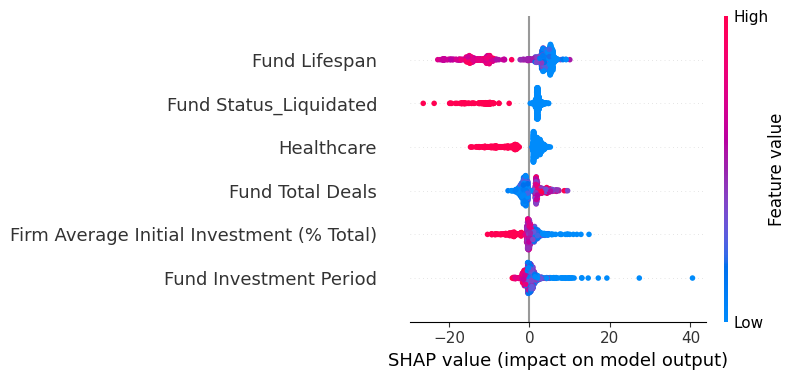

In [ ]:
# === 2) Target3 model: plot SHAP only for features in only_target3 ===
feat_only_t3 = only_target3['Feature'].tolist()
idxs_t3 = [X.columns.get_loc(f) for f in feat_only_t3]
X_t3_subset         = X[feat_only_t3]
shap_vals_t3_subset = shap_values_target3[:, idxs_t3]
shap.summary_plot(
    shap_vals_t3_subset,
    X_t3_subset,
    feature_names=feat_only_t3,
    plot_type="dot",
    show=True
)

## 5.4. Supp Model 4 - RVPI as Target Variable

### 5.4.1. Modelling

XGBoost (target4 - RVPI) - Full R²: 0.8631
XGBoost (target4 - RVPI) - Full RMSE: 38.3860


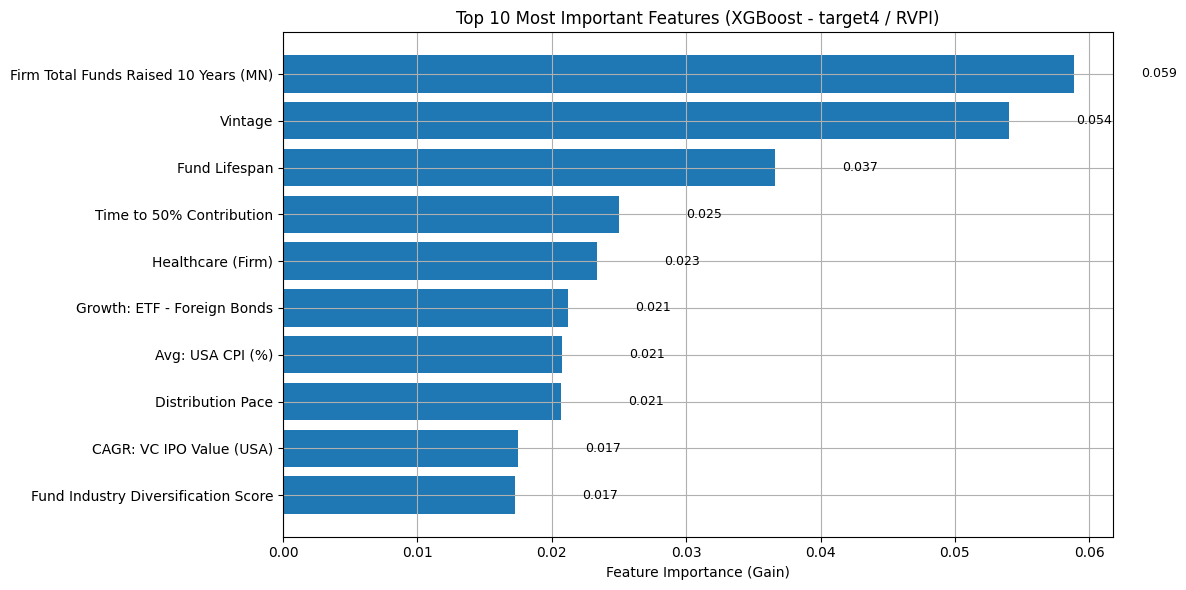

In [ ]:
# === Step 1: Prepare input data for target4 (RVPI) ===
X = df.drop(columns=list(target_cols.values()), errors='ignore')
y = df['target4']

# === Step 2: Impute missing values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# === Step 3: Train XGBoost model with best parameters ===
xgb_model_target4 = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model_target4.fit(X_imputed, y)

# === Step 4: Predict and evaluate on full data ===
y_pred = xgb_model_target4.predict(X_imputed)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"XGBoost (target4 - RVPI) - Full R²: {r2:.4f}")
print(f"XGBoost (target4 - RVPI) - Full RMSE: {rmse:.4f}")

# === Step 5: Plot top N feature importances ===
feature_names = X.columns
importances = xgb_model_target4.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

top_features = [(feature_names[i], importances[i]) for i in indices[:top_n]]
top_features = list(zip(*top_features))  # unzip

plt.figure(figsize=(12, 6))
bars = plt.barh(range(top_n), top_features[1][::-1])  # reversed order

plt.yticks(range(top_n), [top_features[0][i] for i in range(top_n)][::-1])
plt.xlabel("Feature Importance (Gain)")
plt.title(f"Top {top_n} Most Important Features (XGBoost - target4 / RVPI)")
plt.grid(True)

# Add numeric labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (0.005 if width > 0 else -0.005),
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va='center',
        ha='left' if width > 0 else 'right',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# === Step 6: Save results for comparison ===
results_target4 = {
    'model': xgb_model_target4,
    'importance_df': pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True),
    'r2_full': r2,
    'rmse_full': rmse
}


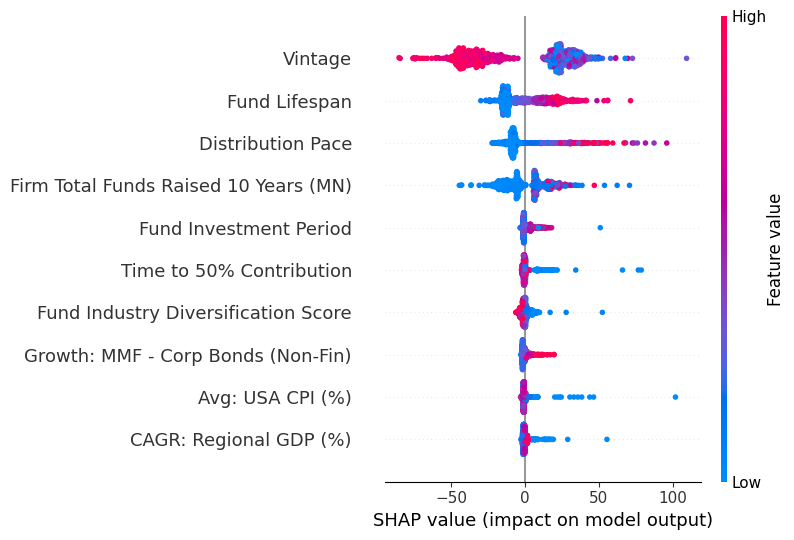

In [ ]:
# === Step 7: SHAP analysis for Target3 (RVPI) Model ===

# Initialize SHAP explainer
explainer_target4 = shap.TreeExplainer(results_target4['model'])

# Compute SHAP values
shap_values_target4 = explainer_target4.shap_values(X_imputed)

# === Step 8: SHAP summary plot (Top 20 features) ===
plt.figure(figsize=(15, 6))
shap.summary_plot(shap_values_target4, X_imputed, feature_names=feature_names, max_display=10, show=True)


### 5.4.2. Comparison between RVPI and IRR as Targets

In [ ]:
import shap
import pandas as pd

# === Step 1: Compute SHAP values for Base and Target4 models ===
explainer_base    = shap.TreeExplainer(results_all['model'])
shap_values_base  = explainer_base.shap_values(X)

explainer_target4 = shap.TreeExplainer(results_target4['model'])
shap_values_target4 = explainer_target4.shap_values(X)

# === Step 2: Build DataFrames of raw SHAP and compute mean absolute SHAP ===
shap_df_base    = pd.DataFrame(shap_values_base,    columns=X.columns)
shap_df_target4 = pd.DataFrame(shap_values_target4, columns=X.columns)

mean_abs_base    = shap_df_base.abs().mean().sort_values(ascending=False)
mean_abs_target4 = shap_df_target4.abs().mean().sort_values(ascending=False)

# === Step 3: Select top N by mean absolute SHAP ===
top_n = 10
top_base = (
    mean_abs_base
    .head(top_n)
    .reset_index()
    .rename(columns={'index':'Feature', 0:'MeanAbs_SHAP_Base'})
)
top_target4 = (
    mean_abs_target4
    .head(top_n)
    .reset_index()
    .rename(columns={'index':'Feature', 0:'MeanAbs_SHAP_Target4'})
)

# === Step 4: Merge and fill missing with zero ===
merged = pd.merge(top_base, top_target4, on='Feature', how='outer').fillna(0)

# === Step 5: Categorize features ===
only_base    = merged[(merged.MeanAbs_SHAP_Base    > 0) & (merged.MeanAbs_SHAP_Target4 == 0)].copy()
only_target4 = merged[(merged.MeanAbs_SHAP_Base    == 0) & (merged.MeanAbs_SHAP_Target4 > 0)].copy()
both         = merged[(merged.MeanAbs_SHAP_Base    > 0) & (merged.MeanAbs_SHAP_Target4 > 0)].copy()

# === Step 6: Sort each table by its SHAP magnitude ===
only_base    = only_base.sort_values('MeanAbs_SHAP_Base',    ascending=False)
only_target4 = only_target4.sort_values('MeanAbs_SHAP_Target4', ascending=False)
both         = both.sort_values(['MeanAbs_SHAP_Base','MeanAbs_SHAP_Target4'], ascending=[False, False])

# === Step 7: Display the sorted results ===
print("🟦 Base-only by MeanAbs SHAP (sorted)")
display(only_base)

print("\n🟥 Target4-only by MeanAbs SHAP (sorted)")
display(only_target4)

print("\n🟪 In both models’ top-10 by MeanAbs SHAP (sorted)")
display(both)


🟦 Base-only by MeanAbs SHAP (sorted)


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Target4
3,CAGR: S&P 500,1.847642,0.0
13,Growth: ETF - Foreign Bonds,0.949670,0.0
12,Fund Size (USD MN),0.808385,0.0
4,Capital Deployment Pace,0.679743,0.0
11,Fund Number Overall,0.622525,0.0
6,Firm Follow-On Rate,0.536875,0.0
2,CAGR: Regional M&A Volume (%),0.515145,0.0



🟥 Target4-only by MeanAbs SHAP (sorted)


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Target4
10,Fund Lifespan,0.0,13.829171
9,Fund Investment Period,0.0,2.627585
15,Time to 50% Contribution,0.0,2.176629
8,Fund Industry Diversification Score,0.0,2.116086
14,Growth: MMF - Corp Bonds (Non-Fin),0.0,1.638168
0,Avg: USA CPI (%),0.0,1.583309
1,CAGR: Regional GDP (%),0.0,1.476654



🟪 In both models’ top-10 by MeanAbs SHAP (sorted)


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_Target4
16,Vintage,1.896311,32.185429
5,Distribution Pace,1.118354,13.321889
7,Firm Total Funds Raised 10 Years (MN),0.993887,12.034586


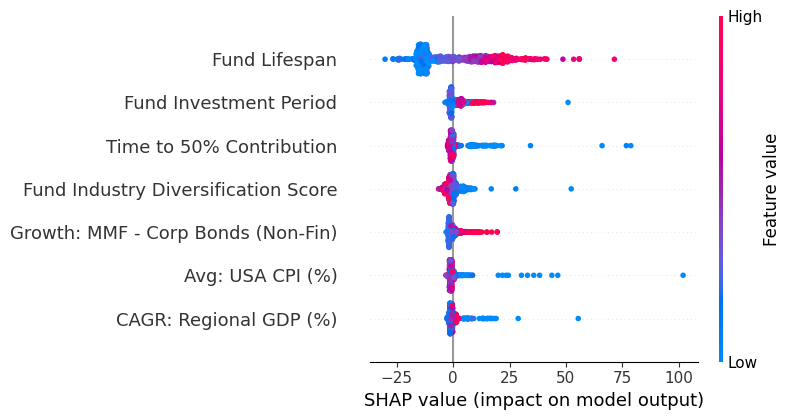

In [ ]:
# === 3) Target4 model: plot SHAP only for features in only_target4 ===
feat_only_t4 = only_target4['Feature'].tolist()
idxs_t4 = [X.columns.get_loc(f) for f in feat_only_t4]
X_t4_subset         = X[feat_only_t4]
shap_vals_t4_subset = shap_values_target4[:, idxs_t4]
shap.summary_plot(
    shap_vals_t4_subset,
    X_t4_subset,
    feature_names=feat_only_t4,
    plot_type="dot",
    show=True
)

## 5.5. Supp Model 5 - Only Fund Industry Focus = Information Technology (IRR Target)

XGBoost (Information Technology) - Full R²: 0.8379
XGBoost (Information Technology) - Full RMSE: 5.7450


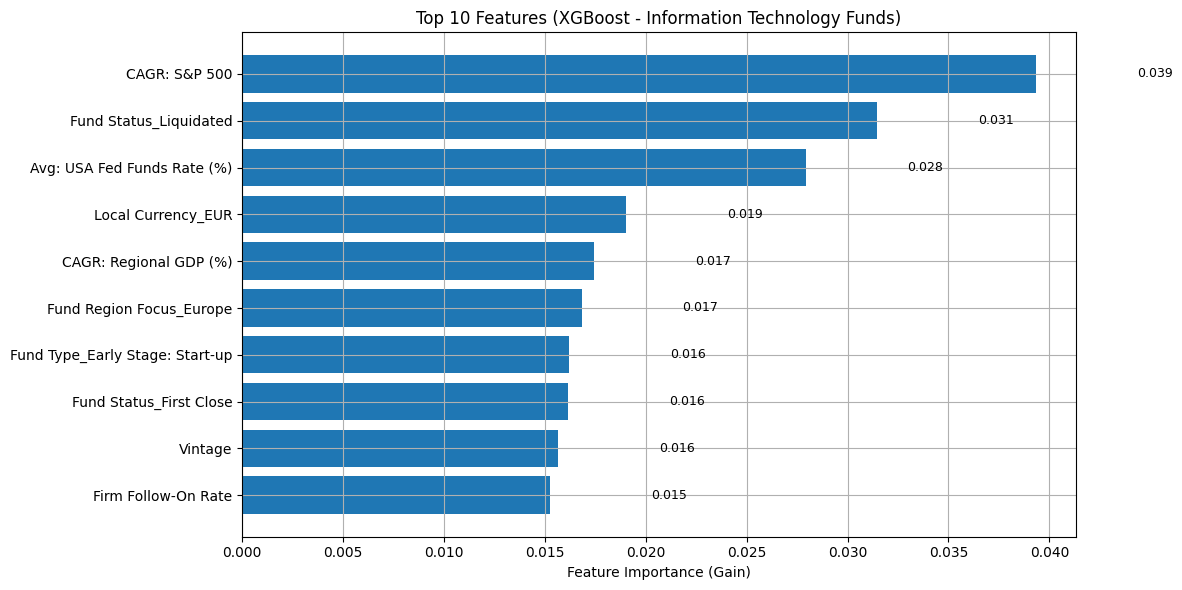

In [ ]:
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and filter only Information Technology focused funds
df_IT = df[df['Information Technology'] == 1].copy()

# Step 2: Drop all target columns except target1
X_it = df_IT.drop(columns=list(target_cols.values()), errors='ignore')
y_it = df_IT['target1']

# Step 3: Impute missing values on full Information Technology dataset
imputer = SimpleImputer(strategy='mean')
X_it_imputed = imputer.fit_transform(X_it)

# Step 4: Define XGBoost model using best parameters (manually entered)
IT_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Step 5: Train on full Information Technology data
IT_model.fit(X_it_imputed, y_it)

# Step 6: Evaluate on full data
y_pred_it = IT_model.predict(X_it_imputed)
r2_it = r2_score(y_it, y_pred_it)
rmse_it = np.sqrt(mean_squared_error(y_it, y_pred_it))

print(f"XGBoost (Information Technology) - Full R²: {r2_it:.4f}")
print(f"XGBoost (Information Technology) - Full RMSE: {rmse_it:.4f}")

# Step 7: Extract feature importance
importance_df_it = pd.DataFrame({
    'Feature': X_it.columns,
    'Importance': IT_model.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Step 8: Plot top features
top_n = 10
top_features_it = importance_df_it.head(top_n)

plt.figure(figsize=(12, 6))
bars = plt.barh(top_features_it['Feature'][::-1], top_features_it['Importance'][::-1])
plt.xlabel("Feature Importance (Gain)")
plt.title(f"Top {top_n} Features (XGBoost - Information Technology Funds)")
plt.grid(True)

# Add numeric labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# Step 9: Store result
results_IT = {
    'model': IT_model,
    'importance_df': importance_df_it,
    'r2_full': r2_it,
    'rmse_full': rmse_it
}


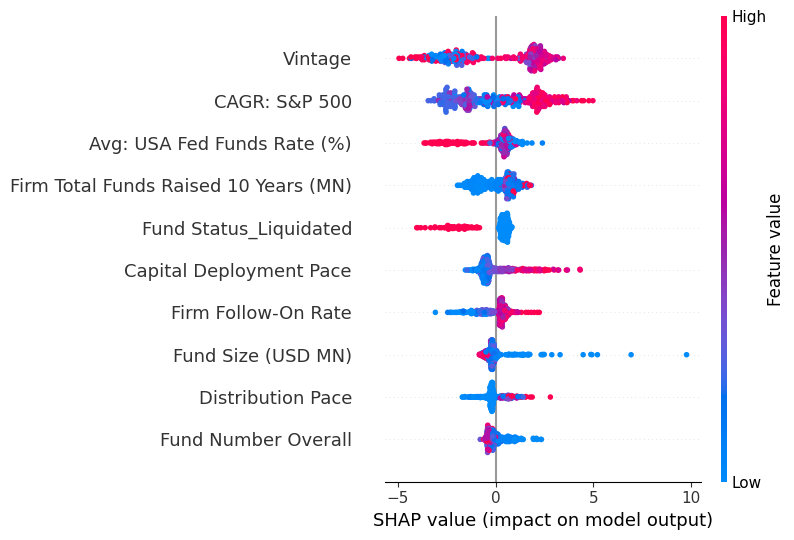

In [ ]:
# === Step 10: SHAP analysis for IT Model ===

# Initialize SHAP explainer
explainer_IT = shap.TreeExplainer(results_IT['model'])

# Compute SHAP values
shap_values_IT = explainer_IT.shap_values(X_it_imputed)

# === Step 11: SHAP summary plot (Top 20 features) ===
plt.figure(figsize=(15, 6))
shap.summary_plot(shap_values_IT, X_it_imputed, feature_names=X_it.columns, max_display=10, show=True)


### Comparison

In [ ]:
import pandas as pd

# Show all rows/columns for clarity
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Number of top features to select
top_n = 10

# === Step 1: Build SHAP DataFrames ===
# (assumes shap_values_base, shap_values_it, X, X_it are already in your namespace)
shap_df_base = pd.DataFrame(shap_values_base, columns=X.columns)
shap_df_it   = pd.DataFrame(shap_values_IT,   columns=X_it.columns)

# === Step 2: Compute mean *absolute* SHAP per feature ===
mean_abs_shap_base = shap_df_base.abs().mean().sort_values(ascending=False)
mean_abs_shap_it   = shap_df_it.abs().mean().sort_values(ascending=False)

# === Step 3: Select top N features by mean abs SHAP ===
top_base = (
    mean_abs_shap_base
    .head(top_n)
    .reset_index()
    .rename(columns={'index':'Feature', 0:'MeanAbs_SHAP_Base'})
)
top_it = (
    mean_abs_shap_it
    .head(top_n)
    .reset_index()
    .rename(columns={'index':'Feature', 0:'MeanAbs_SHAP_IT'})
)

# === Step 4: Merge the two top-10 lists and fill missing with zero ===
merged = pd.merge(top_base, top_it, on='Feature', how='outer').fillna(0)

# === Step 5: Classify into groups ===
only_base = merged[
    (merged.MeanAbs_SHAP_Base > 0) &
    (merged.MeanAbs_SHAP_IT   == 0)
].copy()

only_it = merged[
    (merged.MeanAbs_SHAP_Base == 0) &
    (merged.MeanAbs_SHAP_IT   > 0)
].copy()

both = merged[
    (merged.MeanAbs_SHAP_Base > 0) &
    (merged.MeanAbs_SHAP_IT   > 0)
].copy()

# === Step 6: Sort each table by its SHAP magnitude and reset index ===
only_base = only_base.sort_values('MeanAbs_SHAP_Base', ascending=False).reset_index(drop=True)
only_it   = only_it.sort_values('MeanAbs_SHAP_IT',   ascending=False).reset_index(drop=True)
both      = both.sort_values(
    ['MeanAbs_SHAP_Base','MeanAbs_SHAP_IT'],
    ascending=[False, False]
).reset_index(drop=True)

# === Step 7: Summary counts ===
print(f"Total unique features in either top-{top_n}: {merged.shape[0]}")
print(f"Only in Base top-{top_n}: {only_base.shape[0]}")
print(f"Only in IT top-{top_n}:   {only_it.shape[0]}")
print(f"In both top-{top_n}:       {both.shape[0]}\n")

# === Step 8: Display the results ===
print("🟦 Features only in Base top-10 by MeanAbs SHAP:")
display(only_base[['Feature','MeanAbs_SHAP_Base']])

print("\n🟥 Features only in IT top-10 by MeanAbs SHAP:")
display(only_it[['Feature','MeanAbs_SHAP_IT']])

print("\n🟪 Features in BOTH models' top-10 by MeanAbs SHAP:")
display(both[['Feature','MeanAbs_SHAP_Base','MeanAbs_SHAP_IT']])


Total unique features in either top-10: 12
Only in Base top-10: 2
Only in IT top-10:   2
In both top-10:       8

🟦 Features only in Base top-10 by MeanAbs SHAP:


,Feature,MeanAbs_SHAP_Base
0,Growth: ETF - Foreign Bonds,0.949670
1,CAGR: Regional M&A Volume (%),0.515145



🟥 Features only in IT top-10 by MeanAbs SHAP:


,Feature,MeanAbs_SHAP_IT
0,Avg: USA Fed Funds Rate (%),0.937180
1,Fund Status_Liquidated,0.748965



🟪 Features in BOTH models' top-10 by MeanAbs SHAP:


,Feature,MeanAbs_SHAP_Base,MeanAbs_SHAP_IT
0,Vintage,1.896311,2.143818
1,CAGR: S&P 500,1.847642,1.792480
2,Distribution Pace,1.118354,0.408976
3,Firm Total Funds Raised 10 Years (MN),0.993887,0.770995
4,Fund Size (USD MN),0.808385,0.441352
5,Capital Deployment Pace,0.679743,0.731199
6,Fund Number Overall,0.622525,0.381455
7,Firm Follow-On Rate,0.536875,0.558773


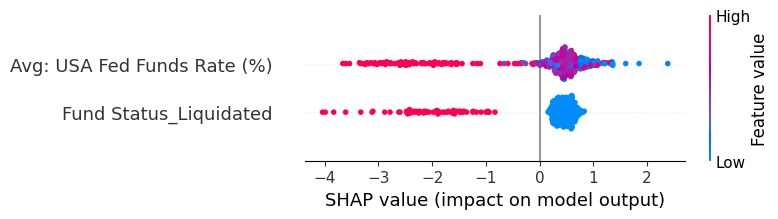

In [ ]:
import shap

# === Plot SHAP summary for IT‐only features ===
feat_only_it = only_it['Feature'].tolist()

# get the column indices in X_it
idxs_it = [X_it.columns.get_loc(f) for f in feat_only_it]

# subset the DataFrame and SHAP array
X_it_subset         = X_it[feat_only_it]
shap_vals_it_subset = shap_values_IT[:, idxs_it]

# make the summary plot
shap.summary_plot(
    shap_vals_it_subset,
    X_it_subset,
    feature_names=feat_only_it,
    plot_type="dot",
    show=True
)
